### Training a local classifier - Deepak Sharma

### Training a local Top Down classifier using CLUSTR HMC Framework on a sample of the Clustr 
### Data Available 

#### Analysis done by Deepak Sharma and Govind Gangadhar

In [1]:
import pickle as pk
import numpy as np

In [2]:
cd ../data

/home/ubuntu/category_hmc/data/crawl_processed_data


In [3]:
with open('sample_clulstr_data.pk', 'rb') as f:
    rolled_up_threshold_3levels_updated = pk.load(f)

In [4]:
rolled_up_threshold_3levels_updated[:10]

[('"Surf Excel Easy Wash - Blue', [['Fabric Care', 'Home Care', 'FMCG']]),
 ('(2 Hour Burn) Decorative Smokeless Tealight Candle',
  [['FMCD'], ['Hardware']]),
 ('(2 Pack) Yardley London Scrub & Smooth Bath Bar, Sea Minerals, 4.5 Oz. (128 G)',
  [['Skin Care', 'Personal Care', 'FMCG']]),
 ('(ON) Gold Standard 100% Whey Protein Powder- 5 lbs',
  [['Health Supplements', 'Healthcare', 'FMCG'],
   ['Health Supplements',
    'Healthcare',
    'Pharmaceuticals and Medical Supplies'],
   ['Health Supplements',
    'Exercise & Fitness',
    'Sports & Fitness Equipment']]),
 ('10 Black Pot Bonhomia Pods Black Tea Capsules Nespresso Compatible',
  [['Tea', 'Beverages', 'FMCG']]),
 ('10 Green Tea Bonhomia Pods Capsules Nespresso Compatible - Green Peace',
  [['Tea', 'Beverages', 'FMCG']]),
 ('100% Freeze - Dried Decaffeinated Coffee - Gold - Nescafe - 100 g',
  [['Coffee', 'Beverages', 'FMCG']]),
 ('100% Freeze - Dried Soluble Coffee - Gold - Nescafe - 200 g',
  [['Coffee', 'Beverages', 'FMCG']])

In [5]:
from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

#from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
#from sklearn_hierarchical_classification.constants import ROOT
#from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled

In [6]:
from gensim.models import Word2Vec

In [7]:
word2vec_model = Word2Vec.load('/home/ubuntu/categorize_segment/embeddings/skip_gram_ATGC_latest/skip_gram_ATGC_latest')

/home/ubuntu/.local/lib/python3.6/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [8]:
def avg_vec_w2v(sentence,model):
    try:
        vec = np.zeros(128, dtype='float')
        length = 0
        for token in sentence:
            if token in model.wv.vocab:
                length += 1
                vec += model.wv[token]
        if length:
            vec = np.array(vec/length,dtype = np.float32)
        return vec
    except Exception as e:
        raise e

In [9]:
def train_avg_w2v(sentences,model):
    matrix = []
    try:
        for sentence in sentences:
            vec = avg_vec_w2v(sentence, model)
            matrix.append(vec)
        matrix = np.array(matrix)
        return matrix
    except Exception as e:
        raise e

In [10]:
##Check if it is same as above function
def preprocessing(string, stopwords_lst=None):
    try:
        clean_string = ''
        if not isinstance(string, str):
            return []
        for s in string:
            if s.isalpha():
                clean_string += s
            else:
                clean_string += ' '
        if stopwords_lst:
            string_tokens = [i.lower() for i in clean_string.split(' ') if i != '' and i not in stopwords_lst]
        else:
            string_tokens = [i.lower() for i in clean_string.split(' ') if i != '']
        return string_tokens
    except:
        print(string)

#### Create the hierarchy of labels

In [14]:
cl_hierarchy = dict()
for x in rolled_up_threshold_3levels_updated:
    for labels in x[1]:
        temp = labels[::-1]
        for i,label in enumerate(temp):
            #print(i)
            #print(label)
            if i == 0:
                if 'ROOT' in cl_hierarchy:
                    if label not in cl_hierarchy['ROOT']:
                        cl_hierarchy['ROOT'].append(label)
                else:
                    cl_hierarchy['ROOT'] = [label]
            else:
                if temp[i-1] in cl_hierarchy:
                    if label not in cl_hierarchy[temp[i-1]]:
                        cl_hierarchy[temp[i-1]].append(label)
                else:
                    cl_hierarchy[temp[i-1]] = [label]

In [15]:
cl_hierarchy['ROOT']

['FMCG',
 'FMCD',
 'Hardware',
 'Pharmaceuticals and Medical Supplies',
 'Sports & Fitness Equipment',
 'Agriculture',
 'Stationery',
 'Automobiles and Accessories',
 'Interiors & Furnishing',
 'Fashion Accessories and Luggage',
 'Toys']

In [16]:
cl_hierarchy.keys()

dict_keys(['ROOT', 'FMCG', 'Home Care', 'Personal Care', 'Healthcare', 'Pharmaceuticals and Medical Supplies', 'Sports & Fitness Equipment', 'Exercise & Fitness', 'Beverages', 'Staples', 'Branded Grocery', 'FMCD', 'Bakery', 'Home Appliances', 'Sweets & Confectionery', 'Stationery', 'Writing Accessories', 'Frozen Food', 'Baby Care', 'Spices', 'Dried Fruits & Nuts', 'Fruits & Vegetables', 'Automobiles and Accessories', 'Dairy', 'Hardware', 'Electrical', 'Diagnostic Instruments', 'Pet Care', 'Air care', 'Car Accessories', 'OTC Medicines', 'Fresh Food Non-veg', 'Interiors & Furnishing', 'Beds', 'Kitchenware', 'Car Care', 'Home Decors', 'Shoe Care'])

In [17]:
import networkx as nx

In [18]:
hier_G = nx.DiGraph(cl_hierarchy)

In [19]:
len(hier_G.nodes)

189

#### Creating Train Test Split by Leaf Node

In [51]:
def aggregate_by_leaf_node(data):
    leaf_nodes_to_index = dict()
    for i, x in enumerate(data):
        for y in x[1]:
            if y[0] in leaf_nodes_to_index:
                leaf_nodes_to_index[y[0]].append(i)
            else:
                leaf_nodes_to_index[y[0]] = [i]
    return leaf_nodes_to_index

In [52]:
temp = aggregate_by_leaf_node(rolled_up_threshold_3levels_updated)

In [53]:
import random

In [54]:
import numpy as np

In [55]:
def sample_leaf_nodes(leaf_to_index):
    train = []
    complete = []
    for k,v in leaf_to_index.items():
        ids = random.sample(v, int(np.floor(len(v)*0.8)))
        #test_ids = list(set(v) - set(ids))
        train.extend(ids)
        complete.extend(v)
    train = list(set(train))
    test = list(set(complete) - set(train))
    return train,test

In [56]:
def generate_train_test(data):
    label_index_dict = aggregate_by_leaf_node(data)
    train_id, test_id = sample_leaf_nodes(label_index_dict)
    train_data = [data[i] for i in train_id]
    test_data = [data[i] for i in test_id]
    return train_data, test_data

In [58]:
tr, te = generate_train_test(rolled_up_threshold_3levels_updated)

#### Creating Product Vector for SKUs

In [59]:
sentences_w2v_train = [preprocessing(x[0]) for x in tr]

In [60]:
vecData_train = train_avg_w2v(sentences_w2v_train, word2vec_model)

In [61]:
vecData_train.shape

(12435, 128)

In [62]:
sentences_w2v_test = [preprocessing(x[0]) for x in te]

In [63]:
vecData_test = train_avg_w2v(sentences_w2v_test, word2vec_model)

In [64]:
vecData_test.shape

(3051, 128)

### Testing the preprocess.py Module 

In [65]:
cd ../src

/home/ubuntu/category_hmc/code


In [21]:
import clustr_hmc.preprocess as pre

In [69]:
labels_train = [list(set([y[0] for y in x[1]])) for x in tr]

In [71]:
np.array(labels_train).shape[0]

12435

In [72]:
labels_test = [list(set([y[0] for y in x[1]])) for x in te]

In [73]:
np.array(labels_test).shape[0]

3051

##### Testing preprocess_label

In [49]:
#dp_test = pre.DataPreprocess(type='LCN')

In [74]:
#path_labels_tr = dp_test.preprocess_label(root='ROOT', G=hier_G, labels=labels_train)

In [75]:
#path_labels_te = dp_test.preprocess_label(root='ROOT', G=hier_G, labels=labels_test)

##### assign_nodes

In [27]:
#hier_G = dp_test.assign_nodes(G=hier_G, labels=path_labels)

In [1]:
#len(hier_G.nodes['FMCD']['X'])

In [2]:
#path_labels[1]

In [3]:
#hier_G.nodes['Hardware']['X']

In [4]:
#len(path_labels)

In [5]:
#dp_test._get_most_specific_for_node(hier_G, 'Hardware')

##### generate samples for local classification

In [34]:
#segments = [s for s in hier_G.successors('ROOT')]

In [43]:
#X, Y = dp_test.generate_samples_for_local_classification(G=hier_G, X=vecData, nodes='Beverages', policy=dp_test._exclusive_siblings_policy)

In [6]:
#X.shape

In [7]:
#from collections import Counter

In [8]:
#Counter(Y)

### Testing traverse.py
### Testing the training and training strategies

In [76]:
from clustr_hmc.classifier import HierarchicalClassifier

In [77]:
#base_est = svm.SVC(gamma=0.001, kernel="rbf", probability=True)

In [102]:
#lcpn
#hier_class = HierarchicalClassifier(base_estimator=None, class_hierarchy=hier_G, prediction_depth='nmlnp', algorithm='lcpn', root='ROOT', label='leaf', do_transform_label=True, multi_label=True, training_stopping_criteria=None, stopping_criteria=0.5)

In [133]:
#lcn
hier_class = HierarchicalClassifier(base_estimator=None, class_hierarchy=hier_G, prediction_depth='nmlnp', algorithm='lcn', root='ROOT', label='leaf', do_transform_label=False, multi_label=True, training_stopping_criteria=None, training_strategy='siblings', stopping_criteria=0.5)

In [261]:
hier_class.fit(X=vecData_train, y=labels_train)

Reach node -  ROOT
Reach node -  FMCG
Reach node -  Home Care
Reach node -  Fabric Care
Reach node -  Cleaning agents & accessories
Reach node -  Religious & Ceremonial
Reach node -  Home Utilities
Reach node -  Disposables
Reach node -  Insect Repellent
Reach node -  Fragrance
Reach node -  Personal Care
Reach node -  Skin Care
Reach node -  Cosmetics
Reach node -  Hair Care
Reach node -  Shaving Needs
Reach node -  Foot & Hand care
Reach node -  Oral Care
Reach node -  Sanitary Needs
Reach node -  Healthcare
Reach node -  Health Supplements
Reach node -  Thilam
Reach node -  Nutrition
Reach node -  OTC Medicines
Reach node -  Digestives
Reach node -  Headache Roll On
Reach node -  Ointments
Reach node -  Essential Oils
Reach node -  Sexual Wellness & Family Planning
Reach node -  Beverages
Reach node -  Tea
Reach node -  Coffee
Reach node -  Fruit Juices
Reach node -  Ayurvedic Juices
Reach node -  Alcoholic Beverages
Reach node -  Energy Drinks
Reach node -  Sparkling Juices
Reach n

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


HierarchicalClassifier(algorithm='lcn', base_estimator=None,
                       class_hierarchy=<networkx.classes.digraph.DiGraph object at 0x7f79e254bc88>,
                       do_transform_label=None, include_parent=False,
                       label='leaf', label_transformer=None, mlb_model=None,
                       multi_label=True, prediction_depth='nmlnp',
                       progress_wrapper=None, root='ROOT',
                       stopping_criteria=0.5, training_stopping_criteria=None,
                       training_strategy='siblings')

In [135]:
import dill

In [149]:
#with open('hmc_model_lcpn_logi_train_test.pkl', 'wb') as f:
#    dill.dump(hier_class,f)

In [151]:
!ls

clustr_hmc				hmc_model.pkl
hmc_decision_trees			hmcnn
hmc_model_lcn_logi_train_test.pkl	hmcnn_train
hmc_model_lcn.pkl			__init__.py
hmc_model_lcn_svm_train_test.pkl	run_model_local.py
hmc_model_lcpn_logistic_train_test.pkl	sklearn_hierarchical_classification
hmc_model_lcpn_svm_train_test.pkl


In [232]:
with open('hmc_model_lcn_logi_train_test.pkl', 'rb') as f:
    hier_class = dill.load(f)

In [153]:
from clustr_hmc.traverse import PredictTraverse

In [164]:
predict = PredictTraverse(G=hier_class.graph_, algorithm=hier_class.algorithm, is_tree=hier_class.is_tree_, is_multi_label=True, prediction_depth=hier_class.prediction_depth, threshold='constant', threshold_value=0.7)

In [165]:
pred_labels = predict.predict(X=vecData_test)

recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.15600721e-03 3.94582891e-04 4.79993106e-03 9.81300331e-01
 3.41580319e-04 1.53315181e-03 2.48348646e-04 6.34454944e-04
 1.45370754e-06 4.85813842e-04 5.81740653e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[8.88634826e-03 3.21573405e-02 3.01952427e-06 9.34408545e-05
 1.08036542e-03 4.44350820e-03 8.55988785e-07 7.13825521e-05
 1.00448713e-03 1.21156989e-05 4.77197079e-04 9.99515968e-01
 7.59733482e-02 8.86814127e-05 1.54612369e-03 1.22713830e-04
 3.86008877e-05 6.27770720e-05]
recursive
Home

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.12408630e-04 4.29919982e-01 1.26638035e-02 6.13522045e-04
 2.71272612e-02 4.18164990e-05 8.89379905e-04 7.20687266e-05
 2.00403514e-03 6.72707245e-04 6.31998154e-03 3.08429942e-04
 1.35912456e-07 1.39697717e-05 9.65604138e-06 4.70337003e-04
 8.05928927e-04 1.27824931e-02]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.998182282336562]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.39542608e-06 1.78277196e-05 8.87597532e-06 9.99629118e-01
 1.13603069e-06 1.82522901e-

In get labels
['Edible Oil' 'Edible seeds' 'Flours' 'Millet' 'Pulses' 'Quinoa' 'Rice'
 'Salt' 'Sugar' 'Wheat']
[2.65980984e-03 5.67939551e-03 2.48450162e-02 5.05094954e-03
 6.30522274e-04 7.98309160e-04 1.31150667e-04 2.16973797e-02
 9.95154996e-01 4.29617868e-04]
recursive
Sugar
In classify
[['ROOT', 'FMCG', 'Staples', 'Sugar']]
[[1.0, 0.9893642866595662, 0.9769641084148917, 0.995154995704593]]
*******************************
[['ROOT', 'FMCG', 'Staples', 'Sugar']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[5.20465415e-05 7.97090987e-05 1.53626159e-04 9.99687930e-01
 5.11722423e-06 2.13575377e-05 1.37067517e-06 6.47199823e-05
 1.06753963e-05 5.53625874e-05 1.74176044e-02]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fru

ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.25225776e-03 3.48431572e-03 5.83401795e-03 9.91875762e-01
 3.66560596e-05 5.09895872e-04 1.80916326e-05 7.19166557e-04
 4.38333507e-05 2.01758858e-04 4.22861147e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[3.14299393e-03 1.83901777e-02 1.00812835e-05 2.10470988e-04
 2.45891127e-05 3.42899151e-04 8.46062044e-06 8.59705458e-04
 1.64526226e-05 1.30544692e-06 8.19513346e-04 1.55190230e-03
 9.98798279e-01 3.78867285e-05 3.61572085e-04 2.56130280e-04
 1.64146011e-03 3.90088998e-05]
recursive
Personal Care


[[1.0, 0.8850460381870396, 0.9898727612877574]]
*******************************
[['ROOT', 'FMCD', 'Kitchenware']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.81012404e-04 6.38416815e-05 3.05142080e-05 9.99972119e-01
 7.86355756e-07 1.56745862e-06 3.00263709e-06 8.81109507e-03
 1.94248946e-03 4.41699291e-06 6.39382305e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.61729254e-06 1.04349872e-03 2.87729805e-06 2.13289097e-04
 3.32203362e-02 1.17702562e-03 8.61243116e-02 1.93203314e-06
 3.66759604e-03 1.93919557e-03 3.89645574e-03 7.823504

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.17244355e-06 9.99447653e-04 1.58500158e-06 1.53283380e-02
 2.99956164e-02 6.07759544e-03 7.21142063e-01 1.36248870e-05
 8.00962386e-04 1.95107182e-03 1.05643046e-03 8.86110347e-05
 6.31633784e-04 1.59004311e-05 6.28935973e-06 4.51121021e-02
 9.66911583e-02 1.19455379e-02]
recursive
Dried Fruits & Nuts
In get labels
['Almonds' 'Cashews' 'Chironji' 'Dates' 'Figs' 'Peanuts' 'Raisin' 'Walnut']
[0.03869664 0.02332507 0.01111641 0.00492786 0.00813092 0.06086786
 0.47969034 0.03449092]
In classify
[['ROOT', 'FMCG', 'Dried Fruits & Nuts']]
[[1.0, 0.9998677798382027, 0.7211420629790501]]
*******************************
[['ROOT', 'FMCG', 'Dried Fruits & Nuts']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and 

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.13214629e-04 3.89659011e-03 4.92666842e-05 2.96888698e-03
 3.53195419e-03 1.98181253e-03 1.25995391e-03 1.15405272e-04
 1.73691449e-04 2.28762347e-04 2.54350672e-05 9.86260312e-01
 3.67968898e-04 5.03135883e-05 6.99939441e-05 8.04351214e-03
 1.58120365e-03 2.57345395e-04]
recursive
Home Care
In get labels
['Cleaning agents & accessories' 'Disposables' 'Fabric Care' 'Fragrance'
 'Home Utilities' 'Insect Repellent' 'Religious & Ceremonial']
[7.67602259e-04 3.62352110e-04 9.99972152e-01 1.52267179e-04
 1.00937965e-03 6.36687226e-05 7.27083832e-03]
recursive
Fabric Care
In classify
[['ROOT', 'FMCG', 'Home Care', 'Fabric Care']]
[[1.0, 0.9951862825834129, 0.9862603124846053, 0.9999721523841524]]
*********************

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[7.79354280e-04 1.24570768e-02 6.74781555e-06 4.38063990e-04
 3.18458717e-04 6.21672824e-03 6.37520361e-06 7.98376451e-05
 7.13595878e-05 2.66791343e-07 1.68110695e-05 9.99637174e-01
 7.75944084e-05 6.53012533e-05 1.73335042e-04 5.58016297e-04
 1.16621180e-04 4.01389750e-05]
recursive
Home Care
In get labels
['Cleaning agents & accessories' 'Disposables' 'Fabric Care' 'Fragrance'
 'Home Utilities' 'Insect Repellent' 'Religious & Ceremonial']
[3.15462112e-04 8.50744251e-05 9.99360993e-01 6.43114792e-04
 7.41688912e-04 1.99138622e-03 2.10697672e-03]
recursive
Fabric Care
In classify
[['ROOT', 'FMCG', 'Home Care', 'Fabric Care']]
[[1.0, 0.9983424494522533, 0.9996371735826033, 0.99936099314898]]
***********************

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.38421540e-04 2.07231442e-04 3.63818775e-03 8.32718069e-04
 6.42916496e-03 5.05679442e-02 6.03799297e-05 9.44855546e-05
 2.69615263e-05 2.50925584e-06 6.80075000e-04 9.62911689e-01
 6.35517047e-03 4.23537957e-05 3.83176660e-05 1.41599833e-03
 1.97810225e-03 6.47246863e-04]
recursive
Home Care
In get labels
['Cleaning agents & accessories' 'Disposables' 'Fabric Care' 'Fragrance'
 'Home Utilities' 'Insect Repellent' 'Religious & Ceremonial']
[1.63655872e-02 1.36107171e-03 8.23494583e-01 6.21396857e-04
 8.94037581e-03 6.14148581e-03 4.75516050e-03]
recursive
Fabric Care
In classify
[['ROOT', 'FMCG', 'Home Care', 'Fabric Care']]
[[1.0, 0.9995782479166401, 0.9629116894592932, 0.8234945828977169]]
*********************

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.34015889e-04 2.92793282e-05 1.11305334e-04 9.98881823e-01
 7.98903288e-03 5.51015174e-03 2.47673059e-07 5.58036360e-05
 1.56029550e-04 3.09828292e-05 2.34584676e-02 2.12819751e-03
 4.02000329e-05 7.01642220e-05 1.30058479e-04 3.62439531e-05
 4.15999703e-05 1.00647163e-02]
recursive
Beverages
In get labels
['Alcoholic Beverages' 'Ayurvedic Juices' 'Coffee' 'Dairy Drinks'
 'Energy Drinks' 'Flavoured Drinks' 'Flavoured Water' 'Fruit Juices'
 'Health Drinks' 'Instant drink mixes' 'Soft Drinks' 'Sparkling Juices'
 'Syrups' 'Tea' 'Water']
[1.50776308e-04 2.67765037e-03 5.39075823e-04 3.09467758e-04
 2.54108815e-02 2.86919870e-02 1.70060034e-03 1.06707955e-03
 2.34577106e-03 7.16606337e-03 8.63424530e-01 7.12838986e-03

In classify
[['ROOT', 'FMCG', 'Personal Care', 'Skin Care']]
[[1.0, 0.9980100474922108, 0.9968036870309559, 0.9995473909403261]]
*******************************
[['ROOT', 'FMCG', 'Personal Care', 'Skin Care']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.17033876e-04 2.87052590e-04 1.80531634e-02 9.84001493e-01
 7.85129179e-05 3.88612387e-03 3.15987155e-04 3.46503611e-03
 8.34162508e-04 1.95465435e-04 9.35131702e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.26604735e-03 5.02044068e-04 4.51273599e-03 6.88588450e-01
 4.54116773e-04 2.1

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[3.55028171e-05 1.09570606e-06 1.12861072e-05 9.99966916e-01
 2.71781207e-06 2.39718610e-05 7.28853511e-07 6.52097316e-06
 4.46213150e-06 2.04335429e-05 5.15984505e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[6.20231672e-07 9.00739030e-04 1.62347625e-04 3.78116552e-04
 9.42163364e-02 5.72668197e-05 2.90541568e-05 9.20063741e-06
 4.93675073e-03 5.09214017e-06 1.02908140e-05 8.32015464e-07
 1.17014633e-05 1.02501752e-03 1.01855446e-05 3.30308758e-03
 1.86164272e-01 9.18389725e-01]
recursive
Sweets & Confection

In get labels
['Butter' 'Buttermilk' 'Cheese' 'Curd' 'Dairy Drinks' 'Dairy Whitener'
 'Fresh cream' 'Ice Cream' 'Lassi' 'Milk' 'Paneer' 'Shrikhand'
 'Whipped cream' 'Yogurt']
[1.90310464e-04 8.78132178e-03 9.04395281e-06 2.94538982e-04
 3.63346649e-01 2.22255108e-02 2.36555343e-02 6.00760881e-04
 1.79285460e-02 9.71346611e-01 1.60593072e-04 2.11011808e-04
 2.30904194e-03 4.14395013e-04]
recursive
Milk
In classify
[['ROOT', 'FMCG', 'Beverages', 'Dairy Drinks'], ['ROOT', 'FMCG', 'Dairy', 'Milk']]
[[1.0, 0.996481541209944, 0.7439753894662411, 0.9907378994546702], [1.0, 0.996481541209944, 0.9970729785948801, 0.9713466105237584]]
*******************************
[['ROOT', 'FMCG', 'Beverages', 'Dairy Drinks'], ['ROOT', 'FMCG', 'Dairy', 'Milk']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[3.35853082e-05 1.45210865e-05 1.40246623e-04 9.99889641e-01
 4.92646879e-07 9.44430619e-07 2.49577184e-06 1.10480896e-02
 1.67790339e-03 5.96853231e-06 3.45129241e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.25832091e-05 2.52559210e-03 2.54672337e-05 3.05605825e-04
 8.07811379e-02 2.47578712e-03 9.03652533e-05 5.66524753e-05
 2.22221710e-03 2.08485038e-06 1.20349554e-02 1.63906657e-04
 6.86917705e-05 6.27322552e-06 9.91558443e-07 9.90346503e-01
 2.30146482e-05 1.39393982e-04]
recursive
Spices
In get label

Branded Grocery
In get labels
['Baking Ingredients' 'Breakfast Cereals' 'Canned Food' 'Chutney'
 'Condiments' 'Cooking Pasta' 'Instant Food' 'Marinade' 'Mouth Freshener'
 'Noodles' 'Pickles' 'Sauces' 'Snacks' 'Vermicelli']
[4.96109569e-03 8.58951198e-04 1.10824737e-04 1.42044188e-03
 5.00175788e-05 8.43303903e-04 8.44448672e-01 8.29869591e-04
 2.92902006e-03 6.04443807e-04 1.18247535e-02 5.96247286e-05
 4.38845688e-03 7.14642944e-02]
recursive
Instant Food
In classify
[['ROOT', 'FMCG', 'Branded Grocery', 'Instant Food']]
[[1.0, 0.9990637609956096, 0.9258425930714533, 0.8444486716503865]]
*******************************
[['ROOT', 'FMCG', 'Branded Grocery', 'Instant Food']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[3.31836057e-04 7.04048021e-06 4.93871247e-03 9.44644719e-01
 5.74165

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.05840664e-04 7.40250122e-05 2.50149307e-05 9.99439077e-01
 8.59686428e-06 4.65377031e-05 4.09558461e-05 1.36621035e-03
 2.12935588e-03 7.90930430e-06 6.57111156e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[7.46404479e-06 2.47728896e-04 4.86769464e-06 3.91320379e-03
 9.17497943e-02 1.52603690e-05 7.72387378e-03 5.47062589e-05
 1.97171742e-03 3.38928096e-02 8.60857876e-04 2.44677292e-04
 1.59401951e-06 8.25205717e-07 6.40460399e-06 3.04330649e-03
 9.06168563e-01 1.17742453e-03]
recursive
Staples
In get labe

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.29660426e-06 4.16829019e-03 6.11069847e-03 2.81408111e-05
 1.82945727e-02 1.73320433e-04 1.09612316e-05 1.41100730e-05
 1.49426740e-03 3.22738912e-06 7.58751179e-04 3.82580965e-03
 5.37866774e-07 1.24430597e-05 1.75915413e-07 1.69809100e-04
 9.96751882e-01 1.99761384e-04]
recursive
Staples
In get labels
['Edible Oil' 'Edible seeds' 'Flours' 'Millet' 'Pulses' 'Quinoa' 'Rice'
 'Salt' 'Sugar' 'Wheat']
[2.65872876e-03 3.72015816e-05 9.96145168e-01 3.07638317e-04
 2.22306932e-04 1.52559526e-04 2.76214315e-04 1.55101087e-03
 2.63859745e-04 5.39047488e-04]
recursive
Flours
In classify
[['ROOT', 'FMCG', 'Staples', 'Flours']]
[[1.0, 0.9999255518366426, 0.99675188188115, 0.9961451675920808]]
******************************

[['ROOT', 'FMCG', 'Staples', 'Salt']]
[[1.0, 0.9866512725214565, 0.9985498688155366, 0.9064802630603792]]
*******************************
[['ROOT', 'FMCG', 'Staples', 'Salt']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.67934162e-04 1.19855186e-05 3.84813545e-05 9.99603912e-01
 5.75699218e-07 5.74577918e-06 1.85065620e-05 8.97585598e-03
 6.00094239e-03 6.34893677e-05 5.09164918e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[4.55750785e-05 2.21140240e-04 2.40253604e-05 5.10279373e-05
 4.50504520e-02 4.99900776e-05 8.42647393e-05 6.36619

FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[7.56587021e-05 1.95250946e-04 8.03613770e-05 3.40651244e-04
 2.66583496e-01 7.58822104e-04 4.83916565e-03 6.32075854e-05
 4.59590782e-02 7.43032679e-03 2.08682312e-02 1.31576406e-05
 2.83438871e-03 7.20501293e-04 3.32856360e-05 3.88215884e-01
 4.39567205e-03 2.98956077e-03]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.9873837025180555]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[9.00810867e-06 2.40428701e-06 2.56160869e-04 9.99850526e-01
 2.04832298e-06 2.9477

In classify
[['ROOT', 'FMCG', 'Staples', 'Edible Oil']]
[[1.0, 0.9999995147905753, 0.9995881146406492, 0.9487699083805234]]
*******************************
[['ROOT', 'FMCG', 'Staples', 'Edible Oil']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.94491989e-06 8.24339188e-06 2.53958743e-04 9.98983412e-01
 8.18786389e-06 4.93035196e-05 2.20833589e-05 1.96300328e-03
 4.55917206e-04 1.17750605e-04 4.98513073e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[5.18380596e-05 3.10931855e-04 1.93092495e-03 7.44759604e-03
 1.07377864e-02 4.47913176e-0

In get labels
['Biscuits' 'Candies' 'Chewing Gum' 'Chocolate' 'Condensed Milk' 'Cookies'
 'Crackers' 'Indian Sweets' 'Jellies' 'Snack bar' 'Spreads' 'Syrups'
 'Toffee']
[3.68475696e-03 1.34860502e-02 6.56869719e-04 9.96848113e-01
 5.27665831e-04 1.74822896e-05 3.90726504e-04 3.49458685e-05
 3.20653047e-04 1.40006042e-04 2.51227534e-04 1.86004028e-05
 7.60717087e-03]
recursive
Chocolate
In classify
[['ROOT', 'FMCG', 'Sweets & Confectionery', 'Chocolate']]
[[1.0, 0.9992641383958415, 0.9996482513190842, 0.9968481128740527]]
*******************************
[['ROOT', 'FMCG', 'Sweets & Confectionery', 'Chocolate']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.28593276e-06 1.27346670e-06 2.94878100e-05 9.99264138e-01
 4.11105962e-07 3.67766554e-06 4.38231136e-05 7.44108847e-04
 3.92375072

ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[4.08090991e-08 1.31921073e-06 1.60484159e-04 9.99806807e-01
 5.06297658e-06 2.35405499e-06 4.16614339e-06 1.52992305e-05
 3.72141816e-06 4.50127553e-06 3.35883819e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.96192420e-05 1.86407616e-06 1.73459422e-05 1.53762999e-05
 3.41476429e-02 4.68938116e-06 1.61723721e-02 2.35874032e-05
 3.46397791e-08 4.54381640e-10 9.12525505e-06 7.10075355e-06
 7.49908294e-06 2.41642976e-04 4.43522928e-06 1.58677083e-03
 2.20182054e-06 9.90987169e-01]
recursive
Sweets & Confe

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.86165302e-04 1.99799434e-04 4.31075221e-04 1.33775462e-05
 3.32127255e-03 1.57099499e-03 5.59968958e-05 3.24955320e-04
 4.14927748e-04 7.05954205e-06 4.63523115e-04 8.72242858e-01
 8.95392283e-01 4.59909830e-04 6.47976717e-03 1.72415234e-04
 5.84234076e-04 2.67835923e-04]
recursive
Home Care
In get labels
['Cleaning agents & accessories' 'Disposables' 'Fabric Care' 'Fragrance'
 'Home Utilities' 'Insect Repellent' 'Religious & Ceremonial']
[0.75465575 0.0053248  0.00080929 0.00122179 0.23102076 0.01659633
 0.00084642]
recursive
Cleaning agents & accessories
recursive
Personal Care
In get labels
['Cosmetics' 'Foot & Hand care' 'Hair Care' 'Oral Care' 'Sanitary Needs'
 'Shaving Needs' 'Skin Care']
[3.92262388e-03 5

[[1.0, 0.9926304086795048]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.35030032e-05 1.19920534e-04 1.18343197e-05 9.99749565e-01
 7.14696338e-05 3.23374957e-06 1.36659269e-05 1.22338211e-04
 2.20824818e-04 1.11068125e-04 4.05825200e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[5.75907804e-04 4.86043009e-03 3.59923648e-02 4.48216718e-03
 5.05199765e-03 1.67914897e-03 9.95173278e-01 1.73598748e-04
 3.74325069e-02 2.22696530e-01 1.20498270e-04 4.63958188e-07
 1.16500910e-02 7.31072590e-

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[5.21759568e-05 1.59306080e-06 4.54386002e-05 5.88856241e-05
 2.34176697e-03 1.22191232e-03 3.23186892e-03 3.22805642e-01
 8.49216697e-01 6.66608845e-03 4.00427728e-03 2.90985227e-03
 7.10789819e-05 1.22373321e-03 1.21763340e-06 9.51911409e-02
 1.71334093e-04 3.46570423e-04]
recursive
Frozen Food
In get labels
['Frozen Beef' 'Frozen Chicken' 'Frozen Fruits & Vegetables'
 'Frozen Mutton' 'Frozen Pork' 'Frozen Seafood' 'Frozen Veg Snacks']
[0.01084047 0.00677639 0.00644574 0.00803712 0.0051377  0.99315839
 0.00760693]
recursive
Frozen Seafood
In classify
[['ROOT', 'FMCG', 'Frozen Food', 'Frozen Seafood']]
[[1.0, 0.9987755938663373, 0.8492166967181516, 0.9931583901113522]]
*******************************
[['ROOT', 'FM

In get labels
['Cleaning agents & accessories' 'Disposables' 'Fabric Care' 'Fragrance'
 'Home Utilities' 'Insect Repellent' 'Religious & Ceremonial']
[0.79880551 0.00242676 0.01021157 0.00502981 0.0480375  0.02858247
 0.00159165]
recursive
Cleaning agents & accessories
In classify
[['ROOT', 'FMCG', 'Home Care', 'Cleaning agents & accessories']]
[[1.0, 0.9591245991025416, 0.875554597664613, 0.7988055075988074]]
*******************************
[['ROOT', 'FMCG', 'Home Care', 'Cleaning agents & accessories']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[4.70450628e-04 3.89141686e-05 1.89208114e-02 9.75501052e-01
 1.12259115e-04 1.28266384e-04 9.86067145e-05 1.87979143e-01
 1.70989453e-02 1.34794782e-05 1.29674706e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverag

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.31974331e-05 1.26496699e-05 1.40871295e-03 9.99130013e-01
 4.69811602e-06 1.11411881e-04 6.46481918e-06 1.19672108e-01
 2.08985808e-03 6.06325233e-03 1.02981218e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[6.25828805e-04 4.80731034e-05 4.76503645e-05 4.70602902e-04
 6.10635295e-04 3.44388313e-02 4.21529308e-04 1.26312399e-03
 1.48690818e-03 6.71305772e-01 2.87015676e-01 9.98508680e-01
 4.58954335e-06 2.58749761e-07 2.13000746e-05 4.65967331e-03
 3.12735410e-02 1.06991397e-04]
recursive
Home Care
In get la

In get labels
['Cosmetics' 'Foot & Hand care' 'Hair Care' 'Oral Care' 'Sanitary Needs'
 'Shaving Needs' 'Skin Care']
[1.39135835e-03 7.40123050e-04 1.88627719e-04 3.02788623e-02
 6.81729539e-03 2.84154774e-03 9.90937440e-01]
recursive
Skin Care
In classify
[['ROOT', 'FMCG', 'Personal Care', 'Skin Care']]
[[1.0, 0.9842776089737915, 0.9679662451956523, 0.9909374400123533]]
*******************************
[['ROOT', 'FMCG', 'Personal Care', 'Skin Care']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[3.29931182e-04 1.13323315e-03 6.49942908e-03 9.66737236e-01
 7.45307449e-05 1.85765402e-04 2.16015379e-05 6.83836844e-04
 4.88788951e-04 1.88594465e-05 3.95267117e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fr

In get labels
['Baking Ingredients' 'Breakfast Cereals' 'Canned Food' 'Chutney'
 'Condiments' 'Cooking Pasta' 'Instant Food' 'Marinade' 'Mouth Freshener'
 'Noodles' 'Pickles' 'Sauces' 'Snacks' 'Vermicelli']
[6.54006195e-04 1.72879270e-03 3.88842586e-01 1.58420997e-05
 3.09203948e-04 4.75895086e-03 2.44660385e-02 5.57527919e-04
 1.77783821e-06 5.21488205e-04 1.57599357e-05 5.37490412e-01
 6.13523799e-02 1.78078343e-05]
In classify
[['ROOT', 'FMCG', 'Branded Grocery']]
[[1.0, 0.9999924728118214, 0.9540741708093106]]
*******************************
[['ROOT', 'FMCG', 'Branded Grocery']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[7.59426205e-04 1.56243878e-03 2.84790797e-04 9.98018106e-01
 1.98434325e-04 1.52741316e-04 6.54248004e-05 4.73367896e-03
 2.41436900e-03 2.00321075e-04 4.33113

[['ROOT', 'FMCG', 'Personal Care', 'Skin Care']]
[[1.0, 0.9993543951476845, 0.9999610167534614, 0.9961209513100396]]
*******************************
[['ROOT', 'FMCG', 'Personal Care', 'Skin Care']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[3.44023746e-04 5.00137038e-04 5.37275083e-04 9.99243631e-01
 1.34168659e-04 1.76885320e-04 9.78047374e-05 4.50724236e-03
 1.41383350e-03 1.61139752e-04 2.64361551e-03]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[5.67247800e-04 1.13349343e-03 1.61080086e-04 4.68955124e-03
 1.13517930e-03 2.02885429e-05 

[['ROOT', 'FMCG', 'Personal Care', 'Skin Care']]
[[1.0, 0.999594551302476, 0.9788320118171383, 0.8849965687033038]]
*******************************
[['ROOT', 'FMCG', 'Personal Care', 'Skin Care']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[7.56762466e-04 8.35024689e-03 1.37243857e-04 9.97043387e-01
 1.09302475e-04 1.17221470e-03 7.06035950e-05 6.08148998e-04
 9.33976735e-06 3.77580089e-04 2.53477278e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[9.99419032e-01 9.24771059e-07 2.87405741e-07 2.23602742e-06
 1.89666750e-03 6.49098311e-05 8

[[1.0, 0.9946840624823712, 0.9252540177017906]]
*******************************
[['ROOT', 'FMCG', 'Personal Care']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[3.08586606e-05 5.52769947e-04 1.89079428e-02 9.55756223e-01
 5.06477289e-04 2.46762139e-03 2.30178440e-04 3.93818517e-03
 6.05549388e-05 1.83363472e-04 9.57322877e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[3.58252222e-04 1.20171620e-02 3.24888701e-04 1.56089439e-02
 7.10061955e-05 1.67529989e-04 3.34647645e-05 1.56749322e-03
 1.88481073e-03 5.18312891e-05 2.32416516e-03 2.8515

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[7.32450286e-05 9.50108900e-07 1.23495143e-04 2.12942778e-01
 6.37339020e-02 3.82023863e-03 7.32025712e-03 5.94632265e-03
 4.47882959e-05 9.50407910e-03 1.35655711e-02 7.00661989e-06
 9.87092174e-01 1.28307331e-02 3.71230457e-05 5.33707106e-03
 1.05843409e-02 2.84430332e-03]
recursive
Personal Care
In get labels
['Cosmetics' 'Foot & Hand care' 'Hair Care' 'Oral Care' 'Sanitary Needs'
 'Shaving Needs' 'Skin Care']
[3.99036444e-04 5.80026170e-03 6.85715804e-03 6.91659498e-03
 9.89650529e-01 4.60021190e-02 1.96095444e-03]
recursive
Sanitary Needs
In classify
[['ROOT', 'FMCG', 'Personal Care', 'Sanitary Needs']]
[[1.0, 0.9600159068580147, 0.9870921741972984, 0.9896505292742135]]
*******************************
[['ROOT'

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.93750543e-04 1.10621873e-04 1.50195239e-03 9.96908983e-01
 1.22300942e-05 8.60533489e-05 5.62517572e-05 6.70578196e-05
 1.46966643e-03 1.20695040e-06 5.17824517e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[3.70135822e-04 6.76109239e-05 5.68672071e-03 2.07567574e-04
 1.02602775e-02 2.70464423e-03 7.36546691e-05 5.80877491e-03
 3.87622521e-03 8.53427682e-03 4.32676712e-05 9.90151842e-06
 7.32868952e-03 1.23811714e-05 1.38240064e-06 2.83002016e-01
 1.31057599e-01 1.37179161e-03]
In classify
[['ROOT', 'FMCG']

In classify
[['ROOT', 'FMCG', 'Staples', 'Pulses']]
[[1.0, 0.9999094596261944, 0.999621744338976, 0.9995642798404138]]
*******************************
[['ROOT', 'FMCG', 'Staples', 'Pulses']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.45951755e-04 8.99619836e-03 9.85413241e-04 9.87786066e-01
 3.36482177e-04 3.19392110e-04 9.59540869e-05 2.11678763e-04
 3.55199177e-04 4.72254989e-03 2.94987814e-03]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[8.97574554e-04 5.38172927e-02 4.16712314e-05 6.38612308e-03
 1.58384900e-04 2.48757839e-05 2.48314

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[3.63283274e-05 4.99309448e-04 4.18746222e-03 9.99246903e-01
 6.07579511e-05 5.08176752e-04 3.53669792e-05 1.99623872e-04
 2.11542696e-03 3.81031931e-05 3.96880417e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[4.13698874e-04 1.15214245e-04 6.28739972e-04 8.41092573e-03
 7.15322385e-02 1.84123493e-04 4.38979148e-02 4.69668939e-03
 1.27032320e-02 7.76253277e-01 4.78026391e-04 3.08392220e-06
 2.14005260e-02 7.11614175e-04 1.63320001e-05 1.06734498e-02
 4.90920642e-03 3.51396839e-02]
recursive
Fruits & Vegetables

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[3.28695911e-05 3.00813729e-05 1.23641536e-02 2.49588717e-02
 3.02961916e-01 5.07026529e-03 6.18768731e-01 1.79527477e-03
 2.10378492e-06 1.35194945e-03 2.52712669e-03 3.41269472e-07
 1.17579574e-04 2.28286469e-04 3.11469611e-05 8.94259507e-03
 9.56194872e-03 6.27039945e-02]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.9996143461480129]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.85773926e-08 1.92131771e-07 6.47317306e-04 9.99915585e-01
 3.01405823e-05 1.31343537e

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.50499640e-06 1.83633623e-04 1.53060136e-04 2.46186488e-04
 2.49003944e-03 5.16391245e-04 9.98066944e-01 2.65676501e-04
 1.05445121e-04 1.63842414e-05 5.71997864e-05 3.93772215e-05
 4.15282257e-08 1.53189407e-05 8.63050528e-07 7.29849616e-04
 9.77872356e-02 5.27821162e-02]
recursive
Dried Fruits & Nuts
In get labels
['Almonds' 'Cashews' 'Chironji' 'Dates' 'Figs' 'Peanuts' 'Raisin' 'Walnut']
[0.00619044 0.98868195 0.00285863 0.00143961 0.00565389 0.00328882
 0.00464827 0.00147942]
recursive
Cashews
In classify
[['ROOT', 'FMCG', 'Dried Fruits & Nuts', 'Cashews']]
[[1.0, 0.9998111729904793, 0.9980669435543104, 0.9886819504871034]]
*******************************
[['ROOT', 'FMCG', 'Dried Fruits & Nuts', 'Cashews']]
r

In get labels
['Alcoholic Beverages' 'Ayurvedic Juices' 'Coffee' 'Dairy Drinks'
 'Energy Drinks' 'Flavoured Drinks' 'Flavoured Water' 'Fruit Juices'
 'Health Drinks' 'Instant drink mixes' 'Soft Drinks' 'Sparkling Juices'
 'Syrups' 'Tea' 'Water']
[9.82196543e-01 4.21560501e-04 1.90363762e-02 3.36248185e-03
 1.03167593e-03 3.31697553e-04 2.91024141e-03 2.25770113e-02
 3.18291896e-04 5.55263547e-03 4.76000981e-02 1.67243586e-03
 1.79000898e-02 2.79923060e-03 2.88838404e-03]
recursive
Alcoholic Beverages
In classify
[['ROOT', 'FMCG', 'Beverages', 'Alcoholic Beverages']]
[[1.0, 0.9950552488249326, 0.8236338466174389, 0.9821965432553446]]
*******************************
[['ROOT', 'FMCG', 'Beverages', 'Alcoholic Beverages']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.09500602e-03 9.1337

Beverages
In get labels
['Alcoholic Beverages' 'Ayurvedic Juices' 'Coffee' 'Dairy Drinks'
 'Energy Drinks' 'Flavoured Drinks' 'Flavoured Water' 'Fruit Juices'
 'Health Drinks' 'Instant drink mixes' 'Soft Drinks' 'Sparkling Juices'
 'Syrups' 'Tea' 'Water']
[2.39168204e-02 8.84454673e-04 2.40070725e-02 1.56023765e-03
 7.28361915e-02 6.91875204e-02 4.92514665e-03 5.39106478e-05
 2.02492160e-03 2.81112790e-03 9.96251816e-01 4.69382154e-03
 4.32122326e-03 1.74041732e-03 5.34582079e-03]
recursive
Soft Drinks
In classify
[['ROOT', 'FMCG', 'Beverages', 'Soft Drinks']]
[[1.0, 0.9999874791242828, 0.9703155489701357, 0.9962518160667251]]
*******************************
[['ROOT', 'FMCG', 'Beverages', 'Soft Drinks']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.26816139e-03 1.18150584e-03 3.884

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.59081525e-06 1.59626200e-05 9.56428959e-06 9.99993124e-01
 2.29808363e-06 4.44270203e-06 2.75094445e-07 3.76377760e-04
 6.18148333e-06 2.15686076e-07 7.11612286e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[3.88011456e-06 5.63284158e-05 1.16907621e-04 1.49784101e-04
 2.72919503e-03 1.44304046e-04 9.07779439e-06 4.15261686e-04
 2.07654463e-05 1.12311088e-04 3.87813947e-04 4.37652233e-05
 1.38855166e-06 1.22149128e-06 2.29900103e-06 9.63986040e-01
 7.97867480e-02 4.96540845e-03]
recursive
Spices
In get label

In classify
[['ROOT', 'FMCG', 'Spices', 'Powdered Spice']]
[[1.0, 0.9999879441976746, 0.9994817066447246, 0.999827547088437]]
*******************************
[['ROOT', 'FMCG', 'Spices', 'Powdered Spice']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[6.38183890e-03 5.44757675e-03 1.75306841e-02 9.57726499e-01
 1.36077561e-04 5.68040700e-04 9.74475339e-05 1.45192844e-02
 3.64296616e-04 2.29816689e-04 8.62839760e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[5.61811310e-03 3.62462738e-03 2.96032631e-05 1.33600537e-03
 6.17241357e-03 6.998919

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[3.76341097e-05 5.91756042e-06 3.12248983e-05 9.99771460e-01
 1.82742062e-07 2.11170639e-07 2.57752714e-07 4.74409539e-03
 2.42894979e-05 2.00093111e-08 1.08189978e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[8.21118125e-06 2.53869569e-04 7.55555015e-03 6.87189409e-07
 3.94414693e-03 2.17103374e-06 4.23554943e-04 2.31596482e-04
 4.13865554e-05 1.35546842e-03 4.84442136e-03 1.97186190e-07
 1.31517284e-05 1.55406998e-06 5.77833440e-07 9.97931014e-01
 6.97769336e-02 1.90100402e-01]
recursive
Spices
In get label

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.29665628e-03 8.15474155e-04 7.98531072e-06 5.24082983e-05
 1.97130008e-04 6.15215204e-05 4.16713068e-05 8.47293789e-04
 2.25720923e-04 4.74559307e-06 1.09009326e-03 3.93545647e-04
 9.99893625e-01 2.83824724e-05 2.88600329e-05 5.61726513e-03
 1.19846733e-02 4.28820652e-04]
recursive
Personal Care
In get labels
['Cosmetics' 'Foot & Hand care' 'Hair Care' 'Oral Care' 'Sanitary Needs'
 'Shaving Needs' 'Skin Care']
[4.71515541e-04 2.50490482e-04 8.81275226e-05 6.97762704e-05
 5.00874776e-04 3.20643699e-03 9.99904051e-01]
recursive
Skin Care
In classify
[['ROOT', 'FMCG', 'Personal Care', 'Skin Care']]
[[1.0, 0.9985253679889232, 0.9998936248022803, 0.999904051201423]]
*******************************
[['ROOT', 'FMCG', '

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[7.00010032e-05 3.07918322e-05 1.79375193e-04 6.93457417e-04
 6.66987339e-01 3.29558158e-04 1.36889749e-05 4.16878528e-06
 1.15856937e-05 4.23555085e-09 2.30266101e-03 5.61706842e-07
 1.13230435e-05 7.45256938e-04 3.74591921e-07 1.26516588e-03
 3.16928480e-01 2.64493256e-01]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.9996975780192741]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.12911179e-04 3.69989199e-07 5.39320052e-07 9.99936010e-01
 1.48802422e-05 8.77747391e

In classify
[['ROOT', 'FMCG', 'Spices', 'Seasonings & rubs']]
[[1.0, 0.9967881380134171, 0.7129916851724607, 0.9394781734295257]]
*******************************
[['ROOT', 'FMCG', 'Spices', 'Seasonings & rubs']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.30138803e-04 3.06836546e-05 1.43126302e-02 9.82123675e-01
 2.63774852e-04 6.29236084e-04 2.46049193e-04 2.53503885e-04
 6.86629484e-06 1.85879008e-04 2.31470990e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[0.00054825 0.0007196  0.00022288 0.0033608  0.12757114 0.0130449
 0.01579355 

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.21699070e-03 2.07681645e-05 7.32309320e-06 2.80531577e-04
 4.06670530e-03 1.36623215e-06 2.85142493e-06 5.11210578e-04
 6.73855490e-05 1.27111373e-04 1.38374912e-02 9.94996028e-01
 7.77783631e-02 2.95752581e-05 1.02135159e-04 7.41996881e-05
 1.34631218e-03 9.68512420e-04]
recursive
Home Care
In get labels
['Cleaning agents & accessories' 'Disposables' 'Fabric Care' 'Fragrance'
 'Home Utilities' 'Insect Repellent' 'Religious & Ceremonial']
[1.45642662e-04 2.34431208e-03 1.26382090e-03 4.68363527e-04
 8.23979430e-03 9.98147234e-01 4.18698776e-03]
recursive
Insect Repellent
In classify
[['ROOT', 'FMCG', 'Home Care', 'Insect Repellent']]
[[1.0, 0.9216633120407597, 0.994996027798657, 0.9981472339331393]]
************

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[5.29299491e-04 3.47614202e-03 6.61420684e-04 1.36051650e-02
 1.52469132e-01 1.96113724e-02 1.79797094e-02 2.25912512e-03
 8.51721057e-04 5.85998403e-03 4.86848751e-03 2.09557238e-03
 1.33825980e-03 3.31916629e-03 1.12274107e-04 6.87371687e-02
 6.39450350e-02 3.03886777e-01]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.9947971421160207]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[8.92910791e-06 7.70790044e-07 1.48681809e-03 9.99380709e-01
 1.68509808e-05 1.64701777e

Baby Food
In classify
[['ROOT', 'FMCG', 'Baby Care', 'Baby Food']]
[[1.0, 0.9998937091607875, 0.8288842605590533, 0.9994659848910001]]
*******************************
[['ROOT', 'FMCG', 'Baby Care', 'Baby Food']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.05476501e-03 4.73834201e-04 5.59057237e-05 9.99221051e-01
 1.77549145e-05 2.10854214e-06 4.27584302e-06 1.26756024e-04
 5.34089538e-03 8.25156084e-07 4.43528263e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[7.59849742e-05 9.93061218e-01 7.97335935e-04 7.52423812e-04
 1.18802126e-02 7

[['ROOT', 'FMCG', 'Home Care', 'Insect Repellent']]
[[1.0, 0.8618933111424922, 0.9407657435422068, 0.9544343177910104]]
*******************************
[['ROOT', 'FMCG', 'Home Care', 'Insect Repellent']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[4.14713329e-05 3.51630013e-05 5.58132477e-02 9.97265017e-01
 1.07518504e-05 4.30736547e-05 7.25794201e-06 7.75253248e-05
 6.38308183e-05 7.48136408e-06 1.19572145e-06]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[3.93800513e-07 2.36220696e-05 3.74784344e-03 5.87232847e-05
 2.94401325e-01 1.7531296

Fruit Juices
In classify
[['ROOT', 'FMCG', 'Beverages', 'Fruit Juices']]
[[1.0, 0.9585404662516507, 0.9914428139473348, 0.9979422812137834]]
*******************************
[['ROOT', 'FMCG', 'Beverages', 'Fruit Juices']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[4.80455335e-04 3.74889325e-05 1.05833824e-03 9.93481111e-01
 7.63789319e-05 1.89169703e-04 3.90034560e-05 1.04139204e-03
 1.71099079e-02 6.93916276e-05 1.16031682e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.36377704e-03 2.30523857e-04 4.33253826e-04 9.48845114e-01
 4.23485

In get labels
['Car Care' 'Home Appliances' 'Home Decors' 'Kitchenware'
 'Media and Office']
[0.00257721 0.01113724 0.00579939 0.99007533 0.00113865]
recursive
Kitchenware
In get labels
['Bowls' 'Casserole' 'Food Container' 'Lunch Box' 'Plastic Container'
 'Tea Strainer' 'Water Bottle']
[0.00408272 0.00464838 0.00278622 0.25267781 0.84380328 0.02243929
 0.01620835]
recursive
Plastic Container
In classify
[['ROOT', 'FMCD', 'Kitchenware', 'Plastic Container']]
[[1.0, 0.8573519456044492, 0.990075328784027, 0.8438032832217612]]
*******************************
[['ROOT', 'FMCD', 'Kitchenware', 'Plastic Container']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[3.62830302e-05 7.11989175e-06 2.40568557e-05 9.99166633e-01
 6.59335162e-05 1.05399323e-04 2.64232427e-05 1.34488399e-01
 4.12135939

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.92880442e-07 1.47460025e-05 1.68181697e-03 1.57458992e-08
 7.45045380e-03 6.02492130e-04 6.37312002e-07 5.81934329e-07
 2.82628598e-05 2.77289223e-06 2.05995252e-07 2.05182456e-04
 4.69249604e-06 2.71574843e-05 4.75009665e-06 2.46237510e-05
 9.49933858e-01 1.44369562e-04]
recursive
Staples
In get labels
['Edible Oil' 'Edible seeds' 'Flours' 'Millet' 'Pulses' 'Quinoa' 'Rice'
 'Salt' 'Sugar' 'Wheat']
[8.64109367e-04 5.01072418e-05 9.98855574e-01 7.08051138e-04
 1.41257584e-04 9.51488968e-04 6.50517596e-04 3.97533258e-05
 4.22459213e-03 2.47578950e-03]
recursive
Flours
In classify
[['ROOT', 'FMCG', 'Staples', 'Flours']]
[[1.0, 0.9998517957215911, 0.949933857835704, 0.9988555741650259]]
*****************************

In classify
[['ROOT', 'FMCG', 'Beverages', 'Fruit Juices']]
[[1.0, 0.9994959733452704, 0.9992062757228358, 0.9851071738105437]]
*******************************
[['ROOT', 'FMCG', 'Beverages', 'Fruit Juices']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[6.23752925e-04 1.19681501e-05 7.44980941e-04 9.98806062e-01
 3.24816299e-05 1.85963537e-05 8.81277645e-06 2.00680630e-02
 3.71839701e-03 1.78061332e-06 1.41665115e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[7.82864870e-05 5.15183019e-04 4.45033897e-04 9.88997809e-01
 2.36239854e-02 3.259

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[7.36775269e-07 2.80106204e-04 1.83993175e-08 2.18202765e-08
 9.45350932e-01 6.57901752e-12 6.43464012e-09 4.75798438e-09
 2.83927649e-03 1.37348413e-04 7.60264082e-12 2.35772345e-05
 1.52452807e-12 2.45474511e-09 2.76806362e-10 2.64314366e-05
 2.01219717e-10 6.03975226e-04]
recursive
Branded Grocery
In get labels
['Baking Ingredients' 'Breakfast Cereals' 'Canned Food' 'Chutney'
 'Condiments' 'Cooking Pasta' 'Instant Food' 'Marinade' 'Mouth Freshener'
 'Noodles' 'Pickles' 'Sauces' 'Snacks' 'Vermicelli']
[1.90762395e-08 6.31321632e-07 1.76574209e-03 3.83194581e-04
 5.37928679e-07 4.46437948e-06 1.60448828e-01 3.58570601e-04
 6.36578829e-06 3.10820191e-05 1.57645172e-04 5.20720484e-06
 9.87828739e-01 6.52663791e-06]


[[1.0, 0.9300191074225725, 0.8545550456834358, 0.8770576326067945]]
*******************************
[['ROOT', 'FMCG', 'Personal Care', 'Skin Care']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.49712661e-04 1.03756931e-05 5.40967835e-04 9.93012457e-01
 6.79487090e-06 1.22454202e-05 8.83493373e-06 3.28003878e-03
 8.22585069e-04 2.73631969e-04 1.27530946e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[9.34630561e-06 8.65772616e-04 8.67736026e-04 1.58025603e-03
 4.76775764e-03 1.60084790e-01 1.59468360e-03 4.03788875e-04
 3.05107619e-04 1.5

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[3.42277120e-04 5.57939643e-05 5.61840091e-04 1.98261848e-03
 8.34239354e-04 9.29897519e-01 3.03700005e-05 5.72945647e-04
 2.11704787e-02 3.19503097e-03 1.45218674e-06 2.30775213e-03
 3.07190155e-05 8.16805429e-03 3.76484177e-05 6.64262762e-03
 1.32819072e-04 9.49745057e-02]
recursive
Dairy
In get labels
['Butter' 'Buttermilk' 'Cheese' 'Curd' 'Dairy Drinks' 'Dairy Whitener'
 'Fresh cream' 'Ice Cream' 'Lassi' 'Milk' 'Paneer' 'Shrikhand'
 'Whipped cream' 'Yogurt']
[1.78501634e-03 2.95761874e-03 9.93472734e-01 4.34429632e-04
 2.12769256e-03 2.07580121e-03 5.41070298e-04 2.70950973e-03
 1.64330116e-05 6.77539020e-04 9.40349289e-03 1.67492517e-04
 4.60849345e-04 8.73630036e-03]
recursive
Cheese
In classify
[['ROOT', 'FM

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.72492155e-04 5.98696991e-04 9.62805692e-04 1.59120146e-02
 3.48315035e-01 7.66621059e-03 1.50840062e-01 1.50873898e-03
 1.45241037e-02 5.93362046e-03 2.57153767e-02 1.94143614e-04
 5.45126233e-04 3.04460064e-04 1.07510729e-05 2.18496759e-02
 6.51831969e-01 1.30796060e-02]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.996737989361349]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.25307465e-05 4.46003870e-05 3.65622438e-05 9.99607180e-01
 3.54988344e-05 1.81382423e-

[[1.0, 0.9869823519153786, 0.9991057457739463]]
*******************************
[['ROOT', 'FMCG', 'Air care']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[8.63493589e-06 1.98563272e-05 3.08662684e-06 9.99987732e-01
 4.48543134e-06 8.52191688e-07 2.66016704e-07 6.30518064e-03
 1.24351955e-03 2.94627423e-06 1.04181813e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.02007798e-05 4.41610904e-04 2.47572396e-03 2.84761880e-04
 6.37601213e-01 1.45713033e-04 1.11895479e-03 2.84634923e-05
 2.16695182e-03 1.58995498e-06 3.38476922e-03 1.48712327e

Air freshener
In classify
[['ROOT', 'FMCG', 'Air care', 'Air freshener']]
[[1.0, 0.9959931400166746, 0.9999954402770701, 0.960450122949548]]
*******************************
[['ROOT', 'FMCG', 'Air care', 'Air freshener']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[7.58511902e-05 2.69764718e-03 7.10984325e-04 9.98673631e-01
 9.31769078e-05 1.18533047e-03 7.75012346e-05 3.58597491e-03
 8.50161041e-06 2.03713890e-05 8.14348259e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[9.95091424e-01 4.32810979e-04 1.30367998e-05 1.17140308e-03
 5.01687

FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[4.93406832e-06 9.90835749e-05 2.68327981e-03 6.53395847e-06
 8.98738241e-01 6.03862914e-04 1.49434029e-02 3.71088745e-03
 1.00058274e-03 2.64449424e-03 7.10246570e-03 9.87681673e-03
 2.36536017e-04 1.16076372e-04 6.26531581e-06 6.30233325e-03
 3.95578342e-02 1.61555699e-02]
recursive
Branded Grocery
In get labels
['Baking Ingredients' 'Breakfast Cereals' 'Canned Food' 'Chutney'
 'Condiments' 'Cooking Pasta' 'Instant Food' 'Marinade' 'Mouth Freshener'
 'Noodles' 'Pickles' 'Sauces' 'Snacks' 'Vermicelli']
[1.93392341e-03 4.00005980e-04 2.84496559e-04 4.97223448e-04
 4.38986495e-04 5.84201759e-03 9.29880769e-01 5.61605802e-04
 4.63359578e-03 1.99448957e-03 8.33577968e-04 1.01813056e-03
 1.08059149e-01 4.68691228e

[['ROOT', 'FMCG', 'Branded Grocery'], ['ROOT', 'FMCG', 'Dairy', 'Cheese']]
[[1.0, 0.999868210591506, 0.7117488344112731], [1.0, 0.999868210591506, 0.8905241222663556, 0.9993176340393513]]
*******************************
[['ROOT', 'FMCG', 'Branded Grocery'], ['ROOT', 'FMCG', 'Dairy', 'Cheese']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[5.11974322e-06 2.88690782e-06 9.17650558e-03 9.97756094e-01
 2.41717530e-04 2.96503915e-05 1.09646589e-05 2.62879650e-05
 7.61664137e-05 1.32348756e-05 9.00572332e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectione

[[1.0, 0.7989185886482333]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[4.59864064e-05 1.94084385e-06 4.92627346e-03 9.90266287e-01
 1.50174835e-05 1.04972498e-05 3.58975488e-05 5.10668814e-05
 7.20725435e-05 1.09609503e-04 2.25913173e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[7.43148421e-05 5.21952469e-05 2.39638576e-03 1.31594617e-04
 7.46688774e-01 9.90353435e-05 1.57885909e-05 4.76099857e-04
 4.08299946e-04 2.12806062e-02 6.59938159e-05 4.08526192e-05
 1.65010080e-05 6.67807053e-

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.58961214e-06 2.91664960e-05 2.51952385e-03 1.06784212e-03
 2.52122185e-01 5.16031599e-03 1.65232979e-03 5.67667491e-04
 1.61504582e-03 5.10433379e-03 3.21335792e-06 9.31599689e-06
 1.17693294e-02 1.67689976e-02 1.17911349e-04 8.15242658e-02
 9.19056944e-01 6.17585890e-03]
recursive
Staples
In get labels
['Edible Oil' 'Edible seeds' 'Flours' 'Millet' 'Pulses' 'Quinoa' 'Rice'
 'Salt' 'Sugar' 'Wheat']
[3.11570001e-04 2.34103780e-02 1.03532679e-03 2.29882386e-03
 9.24754819e-02 6.76973645e-01 3.53943217e-02 1.41520148e-02
 2.53207057e-03 4.82924960e-03]
In classify
[['ROOT', 'FMCG', 'Staples']]
[[1.0, 0.9914634087982508, 0.9190569435677026]]
*******************************
[['ROOT', 'FMCG', 'Staples']]
recursive
ROO

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[5.81256468e-03 3.78833493e-06 1.83601838e-04 7.25745953e-04
 6.07525266e-01 1.92286859e-03 2.93462844e-06 9.96571394e-06
 7.09724231e-04 3.00879629e-04 8.95150710e-03 1.16375633e-04
 2.24008901e-06 3.55351629e-04 1.66621260e-03 1.72259788e-01
 7.64070565e-06 1.07608582e-01]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.959605379883887]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[4.30526162e-03 7.65710222e-04 1.74683570e-02 9.86294772e-01
 2.54542928e-04 1.03775777e-

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[9.13787346e-06 2.28000851e-04 1.68552537e-06 1.75421655e-05
 3.09088144e-02 2.93752832e-05 3.47552835e-05 4.90724830e-06
 8.41349172e-04 9.84615753e-04 4.63141407e-03 2.32695469e-05
 1.62243237e-03 1.20036520e-07 5.53348257e-06 9.56576019e-01
 5.25054028e-02 4.54627382e-04]
recursive
Spices
In get labels
['Cooking Paste' 'Fried Rice Powder' 'Powdered Spice' 'Seasonings & rubs'
 'Whole spices']
[7.42962928e-04 1.60325859e-04 7.77055512e-01 6.85421700e-03
 3.08207678e-02]
recursive
Powdered Spice
In classify
[['ROOT', 'FMCG', 'Spices', 'Powdered Spice']]
[[1.0, 0.9999961050808045, 0.9565760189226011, 0.7770555124228913]]
*******************************
[['ROOT', 'FMCG', 'Spices', 'Powdered Spice']]
recursive
ROOT
In

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.59520421e-05 4.74911783e-03 5.06945464e-05 9.99035290e-03
 5.14076407e-02 8.42621483e-04 1.20313223e-01 3.05423736e-05
 8.43311156e-06 9.18466513e-01 6.85743873e-02 1.78379304e-06
 1.03520785e-02 6.89448369e-05 3.76115940e-06 9.18062813e-04
 1.24963836e-03 6.61546843e-02]
recursive
Fruits & Vegetables
In get labels
['Fruits' 'Vegetables']
[0.99447854 0.00552146]
recursive
Fruits
In classify
[['ROOT', 'FMCG', 'Fruits & Vegetables', 'Fruits']]
[[1.0, 0.9999437625376444, 0.9184665125815072, 0.9944785417742895]]
*******************************
[['ROOT', 'FMCG', 'Fruits & Vegetables', 'Fruits']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.44642515e-04 2.09837638e-03 7.56926872e-05 6.54814307e-04
 3.45135215e-01 2.48162629e-03 9.13984777e-04 1.91568328e-05
 9.28463289e-03 1.39802710e-02 2.18695364e-02 1.26971766e-03
 3.40130327e-04 6.86612489e-06 1.19635950e-05 5.67497269e-01
 1.10351088e-02 7.40883596e-04]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.9999102965788094]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.83236108e-05 1.15567361e-05 4.72750294e-04 9.98387471e-01
 2.92339230e-05 2.36799998e

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.92352888e-04 1.96394939e-04 1.30996800e-04 9.78027533e-01
 2.05368320e-02 8.32795614e-03 5.51013201e-05 6.36637591e-05
 5.62524642e-05 3.72346129e-04 4.00336126e-03 1.84713536e-04
 8.93423310e-04 8.77218944e-05 1.71254181e-05 1.57139418e-06
 2.44424790e-03 8.60096634e-04]
recursive
Beverages
In get labels
['Alcoholic Beverages' 'Ayurvedic Juices' 'Coffee' 'Dairy Drinks'
 'Energy Drinks' 'Flavoured Drinks' 'Flavoured Water' 'Fruit Juices'
 'Health Drinks' 'Instant drink mixes' 'Soft Drinks' 'Sparkling Juices'
 'Syrups' 'Tea' 'Water']
[0.00389476 0.00657883 0.00098319 0.02630117 0.00183245 0.01488106
 0.00610291 0.17610395 0.00030268 0.00194825 0.00977225 0.00284309
 0.00233166 0.00134222 0.02653407]
In classify
[

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[6.04704610e-05 1.07704323e-04 2.24749660e-04 9.94154575e-01
 7.93203136e-05 6.29711610e-04 2.69582291e-04 2.71484833e-02
 2.49227047e-03 4.46270733e-04 7.83862075e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[3.96679164e-04 5.09222801e-01 2.28804370e-05 5.85081501e-03
 1.19032964e-02 2.15495916e-02 1.21696835e-04 5.83159269e-05
 1.41804827e-04 4.25612876e-04 3.38234343e-02 2.33873689e-03
 1.01703939e-01 1.16605681e-03 9.53359723e-05 2.38607973e-06
 3.95479976e-04 7.27773532e-04]
In classify
[['ROOT', 'FMCG']

[['ROOT', 'FMCG', 'Sweets & Confectionery', 'Spreads']]
[[1.0, 0.998796151073949, 0.9845258392136078, 0.9984387157877017]]
*******************************
[['ROOT', 'FMCG', 'Sweets & Confectionery', 'Spreads']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.34648827e-05 5.27815935e-07 8.23875070e-06 9.99942496e-01
 1.50876022e-05 1.52281604e-06 2.17800272e-06 2.65849258e-08
 4.25849595e-08 8.97798927e-05 1.70362658e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.13714309e-06 2.25627586e-06 7.78814882e-04 1.22523846e-04
 1.43953439e-02 7.

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.68507482e-07 7.07406085e-07 9.54436025e-05 9.99989194e-01
 2.52501049e-06 4.22879717e-06 4.42693429e-08 1.29443931e-05
 2.38008308e-06 1.87671741e-06 6.89426519e-06]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.13258441e-05 1.09502216e-04 4.17982710e-04 4.26752401e-03
 9.03527304e-03 9.84375608e-01 7.06643834e-05 9.11482918e-05
 4.76352580e-04 5.54418663e-05 1.15690301e-05 9.65726035e-05
 2.85821806e-08 2.09897551e-04 4.46241511e-07 1.67433047e-03
 1.07845660e-03 1.11049489e-01]
recursive
Dairy
In get labels

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.08553530e-06 9.42429036e-05 5.59059868e-04 4.10192302e-04
 1.76849391e-03 4.91916353e-01 2.16691820e-05 5.43122416e-05
 4.13355510e-03 4.40521144e-04 9.45520039e-06 1.82805209e-07
 2.69897269e-09 2.15764858e-05 8.90364266e-07 2.92986902e-05
 3.70938250e-05 9.03337197e-01]
recursive
Sweets & Confectionery
In get labels
['Biscuits' 'Candies' 'Chewing Gum' 'Chocolate' 'Condensed Milk' 'Cookies'
 'Crackers' 'Indian Sweets' 'Jellies' 'Snack bar' 'Spreads' 'Syrups'
 'Toffee']
[1.39105468e-04 3.87541771e-06 7.54222868e-04 4.56289178e-03
 1.00619641e-03 5.60543532e-04 1.66851003e-03 3.24464451e-03
 4.28546489e-04 2.71815116e-04 9.98349021e-01 5.62151275e-04
 1.14265647e-04]
recursive
Spreads
In classify
[['ROOT', 'FMCG'

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.09461426e-05 7.98700820e-04 1.51097725e-03 2.08199071e-04
 2.03945962e-03 9.28604598e-02 8.80900140e-07 9.79304608e-07
 6.30201813e-05 1.20767416e-08 2.86371060e-05 2.93387325e-07
 1.68465087e-07 1.22397339e-04 3.91164677e-06 2.80435798e-05
 2.86914818e-05 9.99097798e-01]
recursive
Sweets & Confectionery
In get labels
['Biscuits' 'Candies' 'Chewing Gum' 'Chocolate' 'Condensed Milk' 'Cookies'
 'Crackers' 'Indian Sweets' 'Jellies' 'Snack bar' 'Spreads' 'Syrups'
 'Toffee']
[4.80874466e-03 2.06501024e-04 6.50053704e-04 2.38296522e-01
 1.84213895e-03 1.48188880e-02 1.20772752e-03 4.76015190e-04
 2.19674687e-05 2.34735772e-04 2.09303626e-04 1.56463441e-03
 3.22524360e-03]
In classify
[['ROOT', 'FMCG', 'Sweets & Confec

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.06961003e-05 5.70118175e-05 3.55681843e-05 4.49961222e-04
 1.03388830e-03 5.67003094e-03 3.05244695e-03 5.70416946e-01
 4.34782528e-03 3.70845516e-03 2.32767876e-01 1.16615451e-05
 4.28116943e-05 6.92513477e-02 9.28539677e-08 4.65222003e-02
 3.69519869e-04 1.80243616e-04]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.9998002313826163]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.93816415e-04 5.04983672e-05 9.60540646e-04 9.98725477e-01
 7.15261142e-06 8.10473862e

In get labels
['Butter' 'Buttermilk' 'Cheese' 'Curd' 'Dairy Drinks' 'Dairy Whitener'
 'Fresh cream' 'Ice Cream' 'Lassi' 'Milk' 'Paneer' 'Shrikhand'
 'Whipped cream' 'Yogurt']
[1.30979805e-03 1.24189496e-02 4.78153825e-04 7.72473382e-04
 7.23709730e-02 1.32732316e-03 5.93933056e-04 7.40868063e-03
 3.98617128e-03 5.65524832e-01 3.03006798e-04 7.26012942e-03
 1.20183271e-04 1.82082790e-03]
In classify
[['ROOT', 'FMCG', 'Dairy']]
[[1.0, 0.9999405120422326, 0.9352722890466695]]
*******************************
[['ROOT', 'FMCG', 'Dairy']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[3.91460920e-06 2.48627508e-04 2.81647259e-04 9.99667920e-01
 2.69185515e-06 3.33024834e-06 8.72198292e-07 3.24794889e-03
 5.03127165e-04 2.04793219e-05 5.47639823e-06]
recursive
FMCG
In get labels
['Air care' 'B

In classify
[['ROOT', 'FMCG', 'Fruits & Vegetables', 'Vegetables']]
[[1.0, 0.9965671061955782, 0.8896016200808272, 0.9755898713772958]]
*******************************
[['ROOT', 'FMCG', 'Fruits & Vegetables', 'Vegetables']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.32065316e-04 2.15535776e-04 6.33268565e-02 9.56646596e-01
 1.24188213e-05 7.22000839e-04 1.76968627e-05 1.58562108e-03
 2.61421536e-04 5.28683632e-04 1.06220221e-03]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[9.04778442e-04 1.53029513e-06 5.71793646e-04 1.65779305e-03
 9.88

[[1.0, 0.9968875412877468, 0.7108849699840258, 0.9706247670598339], [1.0, 0.9968875412877468, 0.8574059891104698]]
*******************************
[['ROOT', 'FMCG', 'Dairy', 'Ice Cream'], ['ROOT', 'FMCG', 'Sweets & Confectionery']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[4.60790579e-03 1.37802593e-03 4.75041541e-04 8.90943322e-01
 3.02312010e-05 3.40497163e-04 3.86954068e-04 1.16157249e-02
 3.08757631e-04 4.18655709e-03 1.05224458e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[4.93210032e-02 5.35947629e-05 2.56482654e-05 1.88607866e-

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[9.02117536e-07 5.20269341e-05 2.87397324e-04 9.99811333e-01
 3.57805723e-06 1.04752288e-05 2.07806124e-07 1.22040170e-03
 6.09876181e-05 2.85021835e-05 1.66688919e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.21833171e-04 1.51396923e-02 5.98793394e-01 2.77608066e-03
 1.14074874e-02 3.26398862e-02 6.60141990e-05 3.13207183e-04
 8.18957976e-04 1.47464212e-04 1.37495912e-03 1.18389417e-05
 2.83761085e-05 1.45778729e-05 3.52228555e-06 1.94896381e-03
 7.77580165e-03 2.06029610e-01]
In classify
[['ROOT', 'FMCG']

[['ROOT', 'FMCG', 'Branded Grocery', 'Instant Food']]
[[1.0, 0.9993644128929918, 0.9929094710319816, 0.9982650609557407]]
*******************************
[['ROOT', 'FMCG', 'Branded Grocery', 'Instant Food']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.89354071e-05 1.25459285e-03 1.73232491e-04 9.99637583e-01
 9.72049028e-06 8.47944063e-06 2.23903384e-06 3.06387548e-03
 5.09965043e-05 4.48244746e-05 4.10363943e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[5.00342901e-04 3.19806323e-03 1.39691072e-04 9.63772556e-01
 2.41467104e-02 1.578

In classify
[['ROOT', 'FMCG', 'Branded Grocery', 'Noodles']]
[[1.0, 0.9989595263461755, 0.8911669683361039, 0.976684807766697]]
*******************************
[['ROOT', 'FMCG', 'Branded Grocery', 'Noodles']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[5.17551869e-06 4.52180564e-05 1.96562700e-03 9.99512605e-01
 6.10343751e-07 3.00477235e-06 5.58553495e-07 3.86743088e-04
 9.17715999e-06 3.82064932e-06 4.21166944e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.21717160e-04 2.45006255e-07 1.16807272e-04 1.46702316e-05
 3.81176021e-01 2.02

[[1.0, 0.9993128537052496]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.41190754e-08 4.51410265e-06 3.76321192e-05 9.99999577e-01
 1.57889374e-07 4.75989260e-07 3.49028782e-08 1.58328249e-04
 2.60248528e-06 1.06772127e-07 6.01729685e-07]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[7.75814793e-07 3.12573542e-08 4.32439403e-04 3.65043878e-07
 2.55042449e-02 9.98756936e-01 3.94877147e-07 3.05186427e-03
 9.38261182e-05 2.01952932e-07 1.54543139e-04 9.40398201e-05
 2.44407197e-12 1.47697831e-

In get labels
['Butter' 'Buttermilk' 'Cheese' 'Curd' 'Dairy Drinks' 'Dairy Whitener'
 'Fresh cream' 'Ice Cream' 'Lassi' 'Milk' 'Paneer' 'Shrikhand'
 'Whipped cream' 'Yogurt']
[0.01292711 0.00055074 0.00190698 0.00210087 0.10158118 0.02304883
 0.00149717 0.00386661 0.00054228 0.07824845 0.00163581 0.00709705
 0.00041965 0.00037108]
In classify
[['ROOT', 'FMCG', 'Dairy']]
[[1.0, 0.9992033590980106, 0.8732381364056404]]
*******************************
[['ROOT', 'FMCG', 'Dairy']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.75802782e-06 2.94490465e-05 4.63630635e-04 9.99310349e-01
 2.75929277e-07 3.16644999e-06 2.20607522e-06 4.68516773e-04
 1.49948884e-04 2.35280755e-05 8.36150168e-06]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'


[['ROOT', 'FMCG', 'Branded Grocery', 'Noodles']]
[[1.0, 0.9998573910056849, 0.9663182744169545, 0.9971338633176159]]
*******************************
[['ROOT', 'FMCG', 'Branded Grocery', 'Noodles']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.42345602e-06 2.43429515e-05 2.24436791e-03 9.99529355e-01
 4.90723593e-06 2.60666548e-04 2.59442625e-06 2.08166756e-03
 8.71274154e-05 7.33181641e-05 3.14915128e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.34488266e-05 3.05944074e-03 2.61647097e-02 1.16602715e-03
 2.92147509e-02 9.47651685e-01 

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[5.90000958e-08 6.11103838e-03 2.52442612e-02 3.31248216e-07
 9.86139556e-01 2.14682621e-05 3.89681413e-05 4.76991683e-08
 5.46012434e-04 1.99731897e-04 2.41342361e-07 3.26975485e-06
 9.06628198e-09 3.00032179e-06 6.32728807e-08 2.31107818e-04
 5.81806099e-06 4.29033669e-02]
recursive
Branded Grocery
In get labels
['Baking Ingredients' 'Breakfast Cereals' 'Canned Food' 'Chutney'
 'Condiments' 'Cooking Pasta' 'Instant Food' 'Marinade' 'Mouth Freshener'
 'Noodles' 'Pickles' 'Sauces' 'Snacks' 'Vermicelli']
[2.69743086e-06 4.65217501e-05 2.66000232e-05 3.89338767e-03
 5.77363527e-06 1.03757247e-03 1.33941153e-04 1.47978327e-04
 1.79703454e-04 3.88706602e-05 1.95879142e-04 4.57711048e-06
 9.99901124e-01 1.65215975e-04]


In get labels
['Butter' 'Buttermilk' 'Cheese' 'Curd' 'Dairy Drinks' 'Dairy Whitener'
 'Fresh cream' 'Ice Cream' 'Lassi' 'Milk' 'Paneer' 'Shrikhand'
 'Whipped cream' 'Yogurt']
[1.39713891e-03 8.18859984e-04 3.52790668e-03 2.42739699e-02
 1.79757031e-03 4.57281658e-03 5.57055735e-04 3.30866561e-03
 1.16821081e-03 8.36567090e-03 1.91475877e-03 9.54589060e-01
 1.79083169e-04 1.72737603e-03]
recursive
Shrikhand
In classify
[['ROOT', 'FMCG', 'Dairy', 'Shrikhand']]
[[1.0, 0.9999850019957871, 0.9298286045589941, 0.9545890598215139]]
*******************************
[['ROOT', 'FMCG', 'Dairy', 'Shrikhand']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.37660380e-05 1.08442763e-04 1.46431162e-04 9.99744260e-01
 6.22138213e-05 4.23948545e-05 9.57513126e-06 9.64512151e-05
 3.26884881e-04 1.573575

[[1.0, 0.9927722592749889, 0.884795345932801]]
*******************************
[['ROOT', 'FMCG', 'Sweets & Confectionery']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[7.04959553e-07 1.19629910e-06 4.17570523e-06 9.99999338e-01
 3.93272835e-07 1.68289917e-06 9.39617650e-07 8.63271041e-05
 1.42817890e-04 3.65654765e-07 1.53585938e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[5.05081607e-07 1.04519152e-04 1.79667154e-04 4.05599395e-05
 3.41998734e-02 3.31306102e-03 1.82518739e-04 1.54942209e-05
 5.90575912e-05 5.72138947e-04 1.28609619e-0

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.62783287e-04 4.41531587e-04 2.24899678e-03 6.91869132e-02
 7.93008168e-04 9.95591665e-01 9.24457477e-06 1.40081466e-05
 2.88436046e-04 2.16067267e-05 1.41374209e-02 7.68924778e-05
 1.43021411e-03 2.62413747e-06 1.91431684e-05 5.39312698e-05
 4.05836014e-05 9.01538471e-03]
recursive
Dairy
In get labels
['Butter' 'Buttermilk' 'Cheese' 'Curd' 'Dairy Drinks' 'Dairy Whitener'
 'Fresh cream' 'Ice Cream' 'Lassi' 'Milk' 'Paneer' 'Shrikhand'
 'Whipped cream' 'Yogurt']
[6.18304392e-03 1.95051642e-03 3.36710435e-04 1.27317742e-04
 4.02505210e-02 6.89709891e-04 1.93806129e-02 9.60581559e-01
 8.88845734e-04 6.45543253e-04 5.44046512e-04 1.20769107e-03
 1.65212560e-02 2.69391170e-03]
recursive
Ice Cream
In classify
[['ROOT', 

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.61867309e-05 3.74383037e-04 6.81690559e-02 5.77580895e-03
 7.20545599e-02 5.88001822e-03 3.27919423e-04 3.80315218e-04
 9.61592401e-04 2.90163960e-05 2.07208718e-03 1.65877257e-04
 3.62669597e-04 5.26916937e-04 8.79417010e-05 7.82002356e-05
 2.51106197e-03 6.35714638e-01]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.9713351305489054]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[2.99258148e-05 1.45724873e-04 1.00687244e-03 9.96916383e-01
 3.27040862e-05 2.89476307e

[['ROOT', 'FMCG', 'Personal Care', 'Oral Care']]
[[1.0, 0.9905903239579099, 0.8838401618434026, 0.928314634789238]]
*******************************
[['ROOT', 'FMCG', 'Personal Care', 'Oral Care']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[6.72697113e-05 3.15309871e-04 2.58960107e-03 9.98580991e-01
 1.33588379e-05 6.95105888e-06 2.48104827e-06 9.03507263e-05
 1.98005197e-04 2.43811185e-05 2.63558412e-04]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[5.02454453e-06 2.53735333e-04 8.98190197e-03 1.13101636e-04
 2.21869066e-02 7.32412691e-03 1

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.42825459e-05 1.40429840e-05 1.67934518e-02 1.51186364e-02
 1.56534006e-01 2.72250138e-01 1.19741876e-03 5.06408608e-03
 1.07404488e-02 8.01433494e-01 1.36914320e-02 6.30947927e-05
 2.34151420e-05 8.05035974e-04 6.83335686e-07 1.50712780e-03
 1.62923177e-02 2.70110041e-02]
recursive
Fruits & Vegetables
In get labels
['Fruits' 'Vegetables']
[0.98539083 0.01460917]
recursive
Fruits
In classify
[['ROOT', 'FMCG', 'Fruits & Vegetables', 'Fruits']]
[[1.0, 0.9999545256416942, 0.801433494081106, 0.9853908281109568]]
*******************************
[['ROOT', 'FMCG', 'Fruits & Vegetables', 'Fruits']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' '

In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[8.92205029e-05 1.66724481e-04 8.73000570e-03 9.84513064e-01
 1.38274650e-04 2.51683754e-04 7.26422892e-05 4.29086605e-03
 4.67853590e-04 1.04513612e-04 6.42680138e-05]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[8.41889174e-04 4.61157241e-03 1.02342253e-03 1.15175461e-03
 9.64152320e-02 2.65550611e-01 1.67696999e-04 8.24080746e-04
 3.77516279e-03 6.61127891e-04 4.04009324e-03 4.68251225e-03
 5.04345781e-03 1.79145318e-04 7.25773578e-04 4.73988111e-04
 3.86610465e-04 7.67947144e-02]
In classify
[['ROOT', 'FMCG']

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.74934449e-02 1.99722264e-04 1.94831881e-04 6.94276546e-03
 1.37030874e-03 4.22600148e-05 1.11630217e-05 5.97985487e-04
 3.16281473e-04 8.29030517e-06 5.05259195e-02 5.10758605e-03
 8.38931610e-01 1.49601765e-04 5.18214382e-05 4.94998031e-04
 1.34245656e-01 1.34872285e-03]
recursive
Personal Care
In get labels
['Cosmetics' 'Foot & Hand care' 'Hair Care' 'Oral Care' 'Sanitary Needs'
 'Shaving Needs' 'Skin Care']
[2.84928842e-04 4.70919856e-03 9.31140425e-02 7.16907376e-04
 2.97787041e-04 3.09986689e-03 9.30085095e-01]
recursive
Skin Care
In classify
[['ROOT', 'FMCG', 'Personal Care', 'Skin Care']]
[[1.0, 0.9688165371014125, 0.8389316099462155, 0.9300850953097175]]
*******************************
[['ROOT', 'FMCG', 

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.04573771e-03 1.37874395e-05 8.06934541e-05 1.03178048e-04
 1.72971237e-02 1.16983945e-04 3.66340233e-05 1.09276990e-03
 1.26844885e-03 5.26720669e-06 1.81965763e-03 3.88058434e-03
 5.27512131e-05 1.42092739e-04 6.64708881e-06 2.90620263e-05
 2.59844887e-04 9.60619701e-01]
recursive
Sweets & Confectionery
In get labels
['Biscuits' 'Candies' 'Chewing Gum' 'Chocolate' 'Condensed Milk' 'Cookies'
 'Crackers' 'Indian Sweets' 'Jellies' 'Snack bar' 'Spreads' 'Syrups'
 'Toffee']
[4.79439075e-02 4.53391725e-01 1.23821069e-02 1.71088203e-03
 2.29786858e-03 6.59850257e-04 9.55469357e-04 1.19149743e-02
 3.34336057e-03 1.09394992e-03 1.26144300e-03 8.04615066e-05
 3.89405083e-02]
In classify
[['ROOT', 'FMCG', 'Sweets & Confec

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.47459121e-06 1.90208178e-05 2.45930057e-03 1.34768694e-05
 7.73263750e-03 2.62055295e-03 9.90014575e-01 3.19094693e-04
 8.18148818e-04 6.17771872e-03 5.04872504e-03 2.83143162e-05
 3.26934720e-05 9.07239929e-05 1.35296707e-07 3.83362497e-04
 8.73289324e-02 4.80773388e-02]
recursive
Dried Fruits & Nuts
In get labels
['Almonds' 'Cashews' 'Chironji' 'Dates' 'Figs' 'Peanuts' 'Raisin' 'Walnut']
[0.02371661 0.00541368 0.05683117 0.00184519 0.912285   0.00140137
 0.01406566 0.039647  ]
recursive
Figs
In classify
[['ROOT', 'FMCG', 'Dried Fruits & Nuts', 'Figs']]
[[1.0, 0.9999461770687356, 0.990014575073787, 0.9122849987867814]]
*******************************
[['ROOT', 'FMCG', 'Dried Fruits & Nuts', 'Figs']]
recursive
R

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.14866993e-05 2.27506927e-05 4.09961267e-03 1.28640241e-04
 4.20647389e-04 4.04602869e-03 3.76039610e-04 6.64639321e-04
 4.03260737e-01 1.24345656e-04 1.92571169e-05 1.23395940e-04
 2.83568071e-05 7.25068370e-05 1.05705750e-06 9.47917988e-01
 5.82153937e-04 1.27645687e-04]
recursive
Spices
In get labels
['Cooking Paste' 'Fried Rice Powder' 'Powdered Spice' 'Seasonings & rubs'
 'Whole spices']
[1.72414890e-03 1.66615208e-03 9.97396638e-01 6.21027790e-03
 9.01082980e-04]
recursive
Powdered Spice
In classify
[['ROOT', 'FMCG', 'Spices', 'Powdered Spice']]
[[1.0, 0.9998652703312879, 0.9479179883857825, 0.9973966375530074]]
*******************************
[['ROOT', 'FMCG', 'Spices', 'Powdered Spice']]
recursive
ROOT
In

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[8.85713069e-06 1.36648025e-05 1.50760319e-04 6.89031657e-04
 4.38995050e-01 4.63736876e-04 3.01817919e-04 2.61470198e-04
 6.18801723e-03 1.17025637e-04 4.11683102e-06 7.31768398e-06
 2.00445128e-05 1.52551535e-02 3.59824359e-06 2.56944816e-01
 2.17674945e-03 5.13431675e-04]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.9898636874388836]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[6.45334810e-06 3.29609810e-06 2.14356560e-03 9.91155669e-01
 7.12516360e-05 1.42966891e

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[1.31118961e-03 8.10230077e-04 3.82134103e-05 1.44609480e-01
 5.74781024e-03 8.66204669e-04 7.72003669e-05 8.72628039e-06
 1.72232336e-03 1.16078902e-02 1.35817802e-01 1.69971258e-03
 1.08612646e-02 2.74192630e-05 1.79469669e-04 7.61429586e-04
 2.58339568e-02 1.09264424e-02]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.9276385770894492]]
*******************************
[['ROOT', 'FMCG']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.59213463e-03 1.66012971e-04 2.00720770e-04 9.98366251e-01
 2.05997844e-04 4.37033842e

*******************************
[['ROOT', 'FMCG', 'Fruits & Vegetables', 'Fruits']]
recursive
ROOT
In get labels
['Agriculture' 'Automobiles and Accessories' 'FMCD' 'FMCG'
 'Fashion Accessories and Luggage' 'Hardware' 'Interiors & Furnishing'
 'Pharmaceuticals and Medical Supplies' 'Sports & Fitness Equipment'
 'Stationery' 'Toys']
[1.65494624e-04 1.34293054e-04 4.13943188e-03 9.94689616e-01
 7.75208964e-05 3.36987088e-04 1.23728308e-04 9.77405668e-05
 2.49580855e-03 2.58482633e-05 1.77625595e-03]
recursive
FMCG
In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[9.64372638e-04 6.87303559e-04 1.48297654e-02 1.10021917e-03
 8.67348440e-02 6.16448490e-04 1.94019360e-02 5.69724956e-04
 6.34905779e-03 3.61375211e-01 1.63288446e-04 1.73157748e-04
 2.26640974e-03 3.16180

In get labels
['Air care' 'Baby Care' 'Bakery' 'Beverages' 'Branded Grocery' 'Dairy'
 'Dried Fruits & Nuts' 'Fresh Food Non-veg' 'Frozen Food'
 'Fruits & Vegetables' 'Healthcare' 'Home Care' 'Personal Care' 'Pet Care'
 'Shoe Care' 'Spices' 'Staples' 'Sweets & Confectionery']
[2.91064402e-05 1.54636797e-04 1.74272317e-04 2.02266386e-03
 1.20043240e-01 2.00140487e-03 1.55190083e-02 4.03283425e-05
 1.36221849e-07 5.31162586e-03 6.49181311e-05 7.18766162e-03
 2.67769072e-03 2.70702170e-04 8.70588110e-03 8.30601755e-06
 2.27898986e-06 5.87255271e-01]
In classify
[['ROOT', 'FMCG']]
[[1.0, 0.990998419673537]]
*******************************
[['ROOT', 'FMCG']]


In [166]:
pred_labels

[[['ROOT', 'FMCG', 'Home Care', 'Fabric Care']],
 [['ROOT', 'FMCG']],
 [['ROOT', 'FMCG']],
 [['ROOT', 'FMCG']],
 [['ROOT', 'FMCG']],
 [['ROOT', 'FMCG', 'Personal Care', 'Skin Care']],
 [['ROOT', 'FMCG']],
 [['ROOT', 'FMCG']],
 [['ROOT', 'FMCG']],
 [['ROOT', 'Stationery', 'Writing Accessories', 'Pencil']],
 [['ROOT', 'FMCG', 'Staples', 'Pulses']],
 [['ROOT', 'FMCG']],
 [['ROOT', 'FMCG']],
 [['ROOT', 'Stationery', 'Writing Accessories', 'Pencil']],
 [['ROOT']],
 [['ROOT']],
 [['ROOT', 'FMCG', 'Home Care', 'Cleaning agents & accessories']],
 [['ROOT', 'FMCG']],
 [['ROOT', 'Stationery', 'Writing Accessories', 'Pencil']],
 [['ROOT', 'FMCG', 'Beverages', 'Tea']],
 [['ROOT', 'FMCG']],
 [['ROOT', 'FMCG', 'Beverages', 'Tea']],
 [['ROOT', 'Stationery', 'Writing Accessories', 'Pencil']],
 [['ROOT', 'FMCG', 'Baby Care', 'Baby Food']],
 [['ROOT', 'FMCG', 'Baby Care', 'Baby Food']],
 [['ROOT', 'FMCG', 'Baby Care', 'Baby Food']],
 [['ROOT', 'FMCG', 'Beverages', 'Tea']],
 [['ROOT', 'FMCG', 'Personal C

In [89]:
#path_labels_te

In [ ]:
#### Evaluation

In [100]:
#eval_store = dict()

In [167]:
from clustr_hmc import metrics

In [168]:
precision_h = metrics.h_precision_score(path_labels_te, pred_labels)

In [169]:
recall_h = metrics.h_recall_score(path_labels_te, pred_labels)

In [170]:
h_f1 = metrics.h_fbeta_score(path_labels_te, pred_labels)

In [171]:
h_f1

0.8891469405984815

In [172]:
precision_h

0.9639744334689134

In [173]:
eval_store['lcpn_logistic_07'] = (precision_h, recall_h, h_f1)

In [174]:
eval_store

{'lcpn_svm': (0.8856050069541029, 0.8444960212201591, 0.864562118126273),
 'lcpn_logi': (0.9373131703886056, 0.8837035809018567, 0.9097192593224678),
 'lcn_svm': (0.8843183198819752, 0.8446618037135278, 0.8640352736676983),
 'lcn_logi': (0.9390415785764623, 0.8836206896551724, 0.9104885548343014),
 'lcpn_logistic_03': (0.8708518778792848,
  0.9244860742705571,
  0.8968678380443086),
 'lcpn_logistic_07': (0.9639744334689134,
  0.8250994694960212,
  0.8891469405984815)}

In [147]:
eval_store['lcn_logi'] = (precision_h, recall_h, h_f1)

In [132]:
#eval_store['lcn_svm'] = (precision_h, recall_h, h_f1)

In [117]:
#eval_store['lcpn_logi'] = (precision_h, recall_h, h_f1)

In [101]:
#eval_store['lcpn_svm'] = (precision_h, recall_h, h_f1)

In [146]:
eval_store['lcpn_logi']

(0.9373131703886056, 0.8837035809018567, 0.9097192593224678)

In [148]:
eval_store

{'lcpn_svm': (0.8856050069541029, 0.8444960212201591, 0.864562118126273),
 'lcpn_logi': (0.9373131703886056, 0.8837035809018567, 0.9097192593224678),
 'lcn_svm': (0.8843183198819752, 0.8446618037135278, 0.8640352736676983),
 'lcn_logi': (0.9390415785764623, 0.8836206896551724, 0.9104885548343014)}

In [179]:
def _filter_labels(y, node, level):
    y_filtered = []
    indices = []
    for i,y_row in enumerate(y):
        temp = []
        for y_label in y_row:
            if len(y_label) > level:
                if y_label[level] == node:
                    temp.append(y_label[level:])
                    indices.append(i)
        y_filtered.append(temp)
    return y_filtered, indices

In [185]:
def node_precision_recall_scores(y_true, y_pred, node, level):
    """
    Calculate the precision and recall of the given node

    Note that the format expected here for `y_true` and `y_pred` is a
    list of list y_true[0] = [['FMCG', 'SPICES'], ['FMCG', 'STAPLES']] and y_pred similar

    For motivation and definition details, see:

        Functional Annotation of Genes Using Hierarchical Text
        Categorization, Kiritchenko et al 2008

        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.68.5824&rep=rep1&type=pdf

    Parameters
    ----------
    y_true : list of list, Assumes multi-label length of list n_samples
        Ground truth multi-label hierarchical targets.

    y_pred : list of list, Assumes multi-label length of list n_samples
        Predicted multi-label hierarchical targets.

    node : Node on which statistics have to be calculated

    level: Level at which the node is (starts with 0 which is the base case in our case segment)

    Returns
    -------
    Precision, Recall : float
        The computed (micro-averaged) hierarchical precision score.

    """
    assert len(y_true) == len(y_pred), "Length of actual and predicted should be same"
    try:
        y_true_filter, true_ind = _filter_labels(y_true, node, level)
        y_pred_filter, pred_ind = _filter_labels(y_pred, node, level)
        intersection = len(set(true_ind).intersection(set(pred_ind)))
        return float(intersection) / float(len(pred_ind)), float(intersection) / float(len(true_ind))
    except Exception:
        return 0,0

In [186]:
values = dict()
for s in hier_class.graph_.successors('ROOT'):
    values[s] = node_precision_recall_scores(path_labels_te, pred_labels, s, level=1)

In [218]:
labels = dict()
for k,v in values.items():
    labels[k] = str(round(v[0],2))

In [219]:
labels

{'FMCG': '0.97',
 'FMCD': '0.91',
 'Hardware': '0.67',
 'Pharmaceuticals and Medical Supplies': '0.44',
 'Sports & Fitness Equipment': '0.6',
 'Agriculture': '0',
 'Stationery': '1.0',
 'Automobiles and Accessories': '0',
 'Interiors & Furnishing': '1.0',
 'Fashion Accessories and Luggage': '1.0',
 'Toys': '0.5'}

In [234]:
model_logistic_fmcg = hier_class.graph_.nodes['FMCG']['classifier']

In [235]:
pred_probs = model_logistic_fmcg.predict_proba(vecData_test)

In [237]:
pred_probs.shape

(3051, 2)

In [239]:
pred_labels_fmcg, ind = _filter_labels(path_labels_te, 'FMCG', 1)

In [242]:
not_fmcg_ind = [i for i in range(len(path_labels_te)) if i not in ind]

In [244]:
fmcg_pred_probs = [pred_probs[i,0] for i in ind] + [pred_probs[i,0] for i in not_fmcg_ind]

In [245]:
y_fmcg = ['FMCG']*len(ind) + ['NOT_FMCG']*len(not_fmcg_ind)

In [249]:
from sklearn.metrics import roc_curve, auc

In [247]:
fpr,tpr,threshold = roc_curve(y_fmcg, fmcg_pred_probs, pos_label='FMCG')

In [250]:
roc = auc(fpr, tpr)

In [251]:
roc

0.9699565484827455

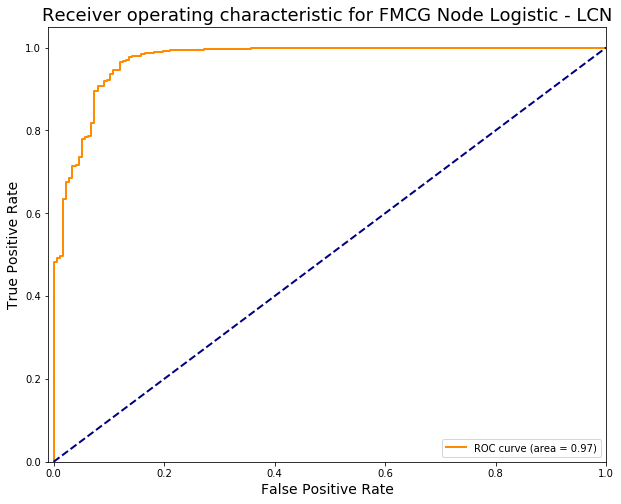

In [256]:
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic for FMCG Node Logistic - LCN', fontsize=18)
plt.legend(loc="lower right")

plt.show()

In [181]:
fmcg_pre, fmcg_recall = node_precision_recall_scores(path_labels_te, pred_labels, 'FMCG', level=1)

In [183]:
fmcg_recall

0.9861207494795281

In [220]:
H = hier_class.graph_.subgraph(['ROOT'] + list(values.keys()))

In [221]:
H

In [28]:
hier_class.graph_.nodes['FMCG']['classifier'].predict_proba(vecData[0,:].reshape(1,-1))

array([[9.05791158e-03, 1.17607763e-01, 6.18246520e-05, 7.24397972e-04,
        4.63654285e-02, 3.59468903e-02, 9.67829207e-06, 5.33231252e-05,
        6.53781841e-04, 2.56371213e-03, 5.97922533e-04, 9.97005479e-01,
        3.84680873e-01, 3.40154040e-06, 5.33674103e-04, 2.02663903e-03,
        9.16410425e-04, 9.68099948e-04]])

In [60]:
hier_class.graph_.nodes['FMCG']['classifier'].classes_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [62]:
hier_class.graph_.nodes['FMCG']['label_transformer'].transformer.classes_

array(['Air care', 'Baby Care', 'Bakery', 'Beverages', 'Branded Grocery',
       'Dairy', 'Dried Fruits & Nuts', 'Fresh Food Non-veg',
       'Frozen Food', 'Fruits & Vegetables', 'Healthcare', 'Home Care',
       'Personal Care', 'Pet Care', 'Shoe Care', 'Spices', 'Staples',
       'Sweets & Confectionery'], dtype=object)

In [38]:
a = np.array([2,3,8,4,5,8])

In [39]:
a[np.where(np.array([2,3,8,4,5,8]) >= 5)[0]]

array([8, 5, 8])

In [65]:
a = True
b = False

In [66]:
if a and (not b):
    print(1)

1


In [64]:
if label == 'askfhk':
    print(1)

In [51]:
hier_class.graph_.nodes['ROOT']['classifier'].predict_proba(vecData[0,:].reshape(1,-1))

array([[1.]])

In [27]:
labels

['Health Supplements', 'Healthcare', 'Pharmaceuticals and Medical Supplies']

In [25]:
from scipy.sparse import csr_matrix
import numpy as np

In [26]:
temp = csr_matrix((1000,20),dtype=np.float64)

In [193]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


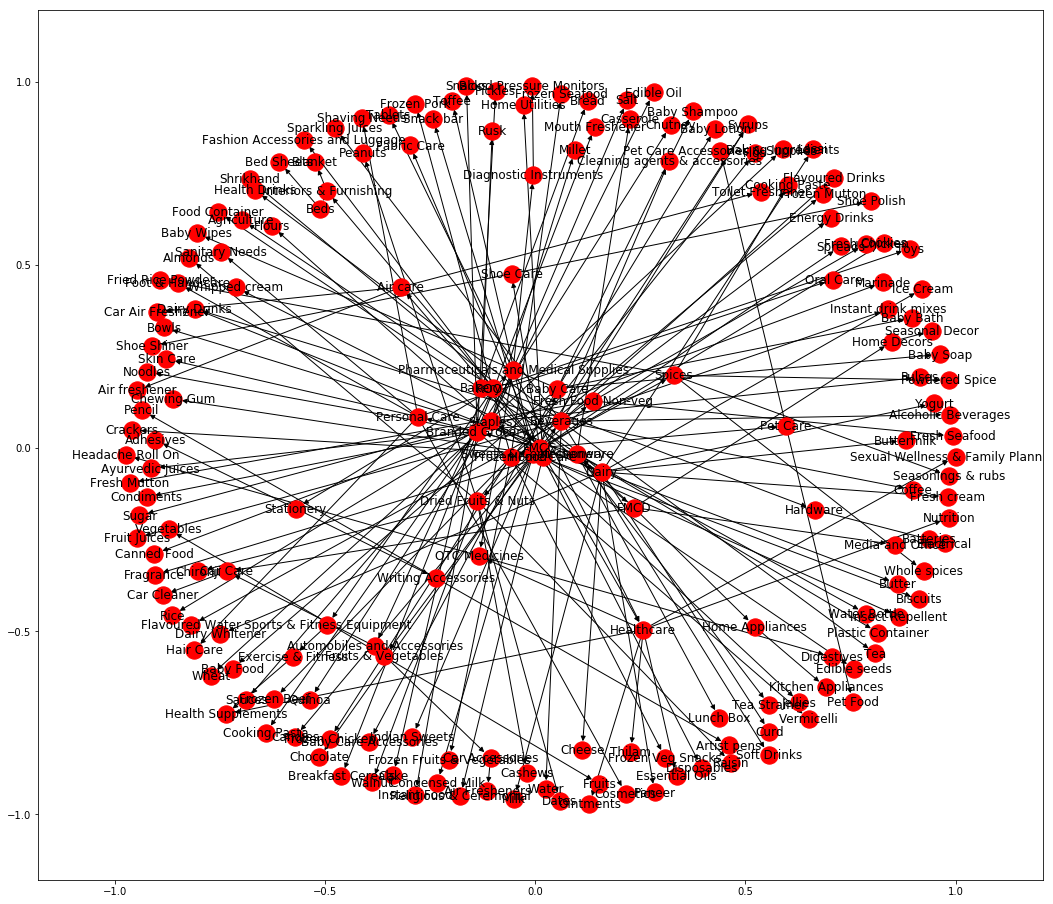

In [28]:
plt.figure(figsize=(18,16))
nx.draw_networkx(hier_G)

In [198]:
import networkx as nx
import random


def hierarchy_pos(G, root=None, width=2, vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    #if not nx.is_tree(G):
    #    raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=2., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [225]:
a = ['FMCG', 'FMCD', 'HW', 'PHARM', 'SPORT', 'AGRI', 'STAT', 'AUTO', 'INTER', 'FASH', 'TOYS']

In [226]:
new_labels = dict()
i = 0
for k,v in labels.items():
    new_labels[k] = a[i]
    i += 1

In [227]:
new_labels

{'FMCG': 'FMCG',
 'FMCD': 'FMCD',
 'Hardware': 'HW',
 'Pharmaceuticals and Medical Supplies': 'PHARM',
 'Sports & Fitness Equipment': 'SPORT',
 'Agriculture': 'AGRI',
 'Stationery': 'STAT',
 'Automobiles and Accessories': 'AUTO',
 'Interiors & Furnishing': 'INTER',
 'Fashion Accessories and Luggage': 'FASH',
 'Toys': 'TOYS'}

In [215]:
new_labels = dict()
count = 1
for node in hier_G.nodes:
    new_labels[node] = str(count)
    count += 1

In [216]:
new_labels

{'ROOT': '1',
 'FMCG': '2',
 'Home Care': '3',
 'Personal Care': '4',
 'Healthcare': '5',
 'Pharmaceuticals and Medical Supplies': '6',
 'Sports & Fitness Equipment': '7',
 'Exercise & Fitness': '8',
 'Beverages': '9',
 'Staples': '10',
 'Branded Grocery': '11',
 'FMCD': '12',
 'Bakery': '13',
 'Home Appliances': '14',
 'Sweets & Confectionery': '15',
 'Stationery': '16',
 'Writing Accessories': '17',
 'Frozen Food': '18',
 'Baby Care': '19',
 'Spices': '20',
 'Dried Fruits & Nuts': '21',
 'Fruits & Vegetables': '22',
 'Automobiles and Accessories': '23',
 'Dairy': '24',
 'Hardware': '25',
 'Electrical': '26',
 'Diagnostic Instruments': '27',
 'Pet Care': '28',
 'Air care': '29',
 'Car Accessories': '30',
 'OTC Medicines': '31',
 'Fresh Food Non-veg': '32',
 'Interiors & Furnishing': '33',
 'Beds': '34',
 'Kitchenware': '35',
 'Car Care': '36',
 'Home Decors': '37',
 'Shoe Care': '38',
 'Agriculture': '39',
 'Fashion Accessories and Luggage': '40',
 'Toys': '41',
 'Fabric Care': '42',


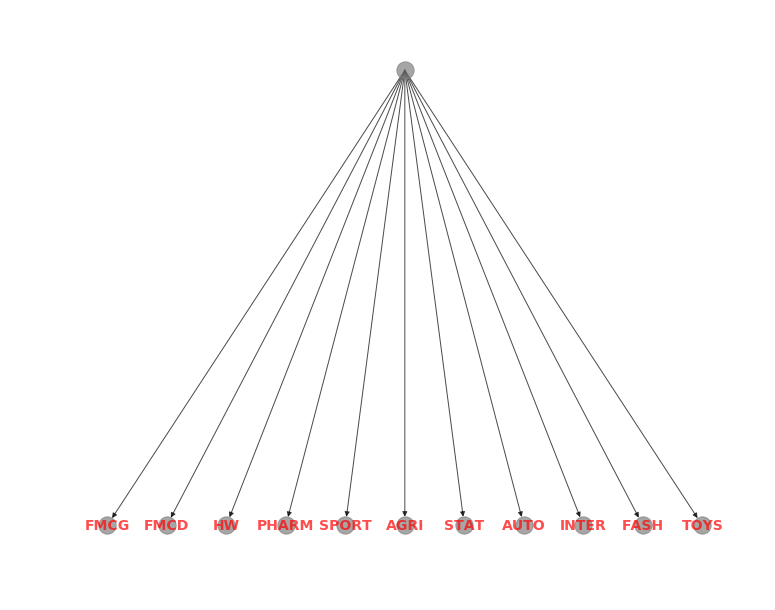

In [231]:
plt.figure(figsize=(10,8))
import matplotlib.pyplot as plt
import networkx as nx
#G=nx.Graph()
#G.add_edges_from([(1,2), (1,3), (1,4), (2,5), (2,6), (2,7), (3,8), (3,9), (4,10),
#                  (5,11), (5,12), (6,13)])
pos = hierarchy_pos(H,'ROOT')    
nx.draw(H, pos=pos, with_labels=True, font_size=14, labels=new_labels, node_color='gray', alpha=0.7, font_color='red', font_weight='bold')
plt.show()
#plt.savefig('hierarchy.png')

#### Preparing Training Data

#### Creating the training Y with only leaf nodes and then a label binarizer

In [66]:
Y_model = []
for x in tr:
    Y_model.append([l[0] for l in x[1]])

In [67]:
Y_model = [tuple(y) for y in Y_model]

#### I checked that there are cases where multiple paths lead to the same result

#### Multi Label Binarizer

In [68]:
from sklearn.preprocessing import MultiLabelBinarizer

In [69]:
mlb = MultiLabelBinarizer()

In [70]:
Y_multi_label = mlb.fit_transform(Y_model)

In [72]:
Y_multi_label

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [71]:
Y_multi_label.shape

(12430, 179)

In [48]:
base_est = svm.SVC(gamma=0.001, kernel="rbf", probability=True)

In [49]:
cd /home/ubuntu/category_hmc/code

/home/ubuntu/category_hmc/code


In [50]:
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled

In [51]:
from importlib import reload

In [52]:
#reload(HierarchicalClassifier)

In [53]:
hier_class = HierarchicalClassifier(base_estimator=base_est, class_hierarchy=hier_G, prediction_depth='nmlnp', algorithm='lcpn', root='ROOT', feature_extraction='preprocessed', mlb=mlb, stopping_criteria=0.5, mlb_prediction_threshold=0.5)

In [54]:
from scipy import sparse

In [55]:
vecData_Sparse = sparse.csr_matrix(vecData_train) 

In [56]:
hier_class.fit(vecData_Sparse, Y_multi_label)

HierarchicalClassifier(algorithm='lcpn',
                       base_estimator=SVC(C=1.0, break_ties=False,
                                          cache_size=200, class_weight=None,
                                          coef0=0.0,
                                          decision_function_shape='ovr',
                                          degree=3, gamma=0.001, kernel='rbf',
                                          max_iter=-1, probability=True,
                                          random_state=None, shrinking=True,
                                          tol=0.001, verbose=False),
                       class_hierarchy=<networkx.classes.digraph.DiGraph object at 0x7fbd66563860>,
                       feature_extraction='preprocessed',
                       mlb=MultiLabelBinarizer(classes=None,
                                               sparse_output=False),
                       mlb_prediction_threshold=0.5, prediction_depth='nmlnp',
                       p

In [57]:
hier_class.graph_.nodes['ROOT']['classifier']

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=0.001, kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [58]:
hier_class.graph_.nodes['ROOT']['classifier_MLB'].classes_

array(['Agriculture', 'Automobiles and Accessories', 'FMCD', 'FMCG',
       'Fashion Accessories and Luggage', 'Hardware',
       'Interiors & Furnishing', 'Pharmaceuticals and Medical Supplies',
       'Sports & Fitness Equipment', 'Stationery', 'Toys'], dtype=object)

#### Testing on the holdout data

In [60]:
vecData_Sparse_test = sparse.csr_matrix(vecData_test) 

In [61]:
pred_test = hier_class.predict(vecData_Sparse_test)

In [62]:
pred_test[:20]

array([list([['FMCG']]), list([['FMCG']]), list([['FMCG']]),
       list([['FMCG', 'Fruits & Vegetables']]),
       list([['FMCG', 'Dried Fruits & Nuts']]), list([]),
       list([['FMCG', 'Personal Care']]),
       list([['FMCG', 'Personal Care']]), list([['FMCG', 'Staples']]),
       list([['FMCG']]), list([['FMCG', 'Sweets & Confectionery']]),
       list([['FMCG', 'Staples']]), list([['FMCG', 'Staples']]),
       list([['Stationery', 'Writing Accessories']]),
       list([['FMCG', 'Staples']]),
       list([['Stationery', 'Writing Accessories']]),
       list([['Stationery', 'Writing Accessories']]), list([]), list([]),
       list([['FMCG', 'Fruits & Vegetables']])], dtype=object)

In [63]:
te[:10]

[('100% Kiwi Olive Oil Extra Virgin 250ml',
  [['Edible Oil', 'Staples', 'FMCG']]),
 ('100% Kiwi Olive Oil Extra Virgin 500ml',
  [['Edible Oil', 'Staples', 'FMCG']]),
 ('Apricot Stainless Steel Dinner Set, 22 pcs', [['Kitchenware', 'FMCD']]),
 ('Apricot Turkish Dried Town', [['Dried Fruits & Nuts', 'FMCG']]),
 ('Apricots 400gm Pouch', [['Fruits', 'Fruits & Vegetables', 'FMCG']]),
 ('12 Piece Chocolate Box - Smoor - 1 U',
  [['Chocolate', 'Sweets & Confectionery', 'FMCG']]),
 ('April Violets For Women By Yardley Of London Eau De Toilette Spray 4.2 Oz',
  [['Skin Care', 'Personal Care', 'FMCG']]),
 ('Apsa-80 Adjuvant Spray(500 Ml)', [['Agriculture']]),
 ('15 Chana Dal 500gms', [['Pulses', 'Staples', 'FMCG']]),
 ('APSARA ABSOLUTE PREMIUM PENCIL PK10',
  [['Pencil', 'Writing Accessories', 'Stationery']])]

In [64]:
from sklearn_hierarchical_classification import metrics

In [70]:
y_true = [[y[::-1] for y in x[1]] for x in te]

In [72]:
metrics.h_precision_score(y_true, pred_test)

0.9023362023537678

In [73]:
metrics.h_recall_score(y_true, pred_test)

0.5698280643372158

##### Testing Node Level Precision and Recall

In [76]:
metrics.node_precision_recall_scores(y_true, pred_test, 'Stationery', 0)

(0.96875, 0.7948717948717948)

#### Calculating the probabilities of prediction

In [68]:
pred_test_prob = hier_class.predict_proba(vecData_Sparse_test)